# 2023 빅콘테스트
## 정형데이터 분석 분야 - 어드밴스드 리그
주제 : 클래식 공연 활성화를 위한 예술의 전당 콘서트홀의 효과적 가격 모델 수립
- 팀 : 투리
- 구성원
    - 팀장 이지은 010-8763-6757 1016jane@korea.ac.kr
    - 팀원 이채영 010-4056-9628 lcy0702018@gmail.com

# 0. 모듈 import

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
from IPython.display import Image, display, Markdown
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.cm as cm
import math
import seaborn as sns
from matplotlib import rc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold

# 1. Data load

In [2]:
# set data dir.
data_dir = "/disk1_ssd/bilje/big/"
os.chdir(data_dir)

In [3]:
# data load
original_data = pd.read_csv('./DATA.csv')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
data = original_data

In [6]:
# 경고 무시
warnings.filterwarnings('ignore')

# 2. EDA

In [32]:
data_for_eda = original_data

# 데이터 살펴보기
print("Data Overview:")
print(data_for_eda.head())

# 데이터 정보 확인
print("\nData Information:")
print(data_for_eda.info())

# 기술통계 확인
print("\nDescriptive Statistics:")
print(data_for_eda.describe())

# 결측치 확인
print("\nMissing Values:")
print(data_for_eda.isnull().sum())

# 각 변수별 unique 값 확인
print("\nUnique Values for Each Column:")
for col in data_for_eda.columns:
    print(f"{col}: {data_for_eda[col].unique()}")

Data Overview:
    age gender membership_type_1 membership_type_2 membership_type_3  \
0  50.0      F                골드                무료                그린   
1   NaN    NaN               NaN               NaN               NaN   
2   NaN    NaN               NaN               NaN               NaN   
3   NaN    NaN               NaN               NaN               NaN   
4  50.0      M                무료               NaN               NaN   

  membership_type_4 membership_type_5  membership_type_6  tran_date  \
0               NaN               NaN                NaN   20220114   
1               NaN               NaN                NaN   20211003   
2               NaN               NaN                NaN   20220917   
3               NaN               NaN                NaN   20190630   
4               NaN               NaN                NaN   20220206   

   tran_time  play_date  play_st_time          seat   price  ticket_cancel  \
0       1512   20220204          2000    3층 BOX

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


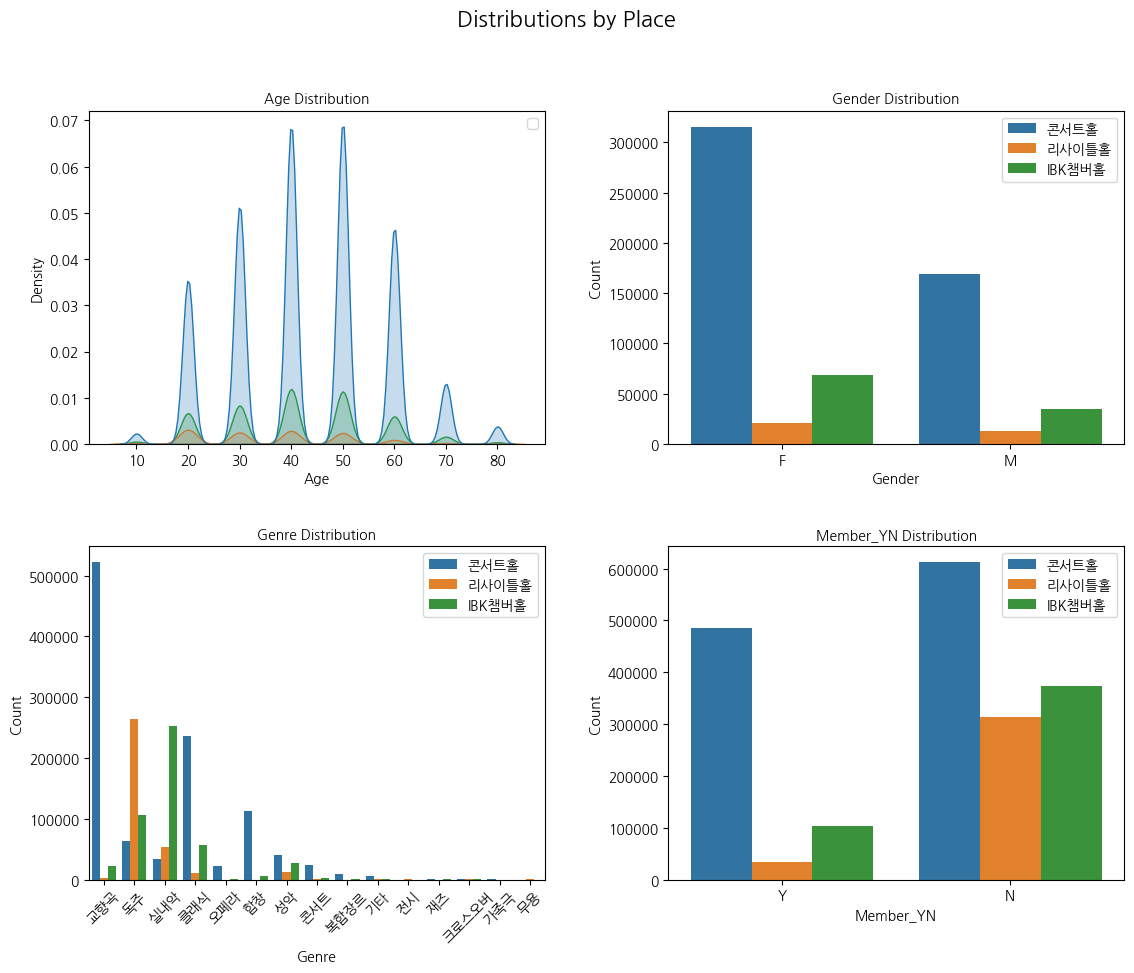

In [33]:
# 한글 폰트 설정
font_path = "./NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path)

def plot_histograms_by_place(data):
    # 필요한 데이터 추출 (age, gender, genre, member_yn, place)
    filtered_data = data[data['place'].isin(['콘서트홀', '리사이틀홀', 'IBK챔버홀'])]
    filtered_data = filtered_data[['age', 'gender', 'genre', 'member_yn', 'place']]
    
    # 2x2 서브플롯 생성
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Distributions by Place', fontsize=16, fontproperties=font_prop)

    # age에 대한 KDE plot
    sns.kdeplot(data=filtered_data, x='age', hue='place', ax=axes[0, 0], fill=True)
    axes[0, 0].set_title('Age Distribution', fontproperties=font_prop)
    axes[0, 0].set_xlabel('Age', fontproperties=font_prop)
    axes[0, 0].set_ylabel('Density', fontproperties=font_prop)
    
    # gender에 대한 히스토그램
    sns.countplot(data=filtered_data, x='gender', hue='place', ax=axes[0, 1])
    axes[0, 1].set_title('Gender Distribution', fontproperties=font_prop)
    axes[0, 1].set_xlabel('Gender', fontproperties=font_prop)
    axes[0, 1].set_ylabel('Count', fontproperties=font_prop)
    
    # genre에 대한 히스토그램
    sns.countplot(data=filtered_data, x='genre', hue='place', ax=axes[1, 0])
    axes[1, 0].set_title('Genre Distribution', fontproperties=font_prop)
    axes[1, 0].set_xlabel('Genre', fontproperties=font_prop)
    axes[1, 0].set_ylabel('Count', fontproperties=font_prop)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # member_yn에 대한 히스토그램
    sns.countplot(data=filtered_data, x='member_yn', hue='place', ax=axes[1, 1])
    axes[1, 1].set_title('Member_YN Distribution', fontproperties=font_prop)
    axes[1, 1].set_xlabel('Member_YN', fontproperties=font_prop)
    axes[1, 1].set_ylabel('Count', fontproperties=font_prop)
    
    # 서브플롯 간 간격 조절
    plt.tight_layout(pad=3.0)
    
    # 한글 폰트 적용
    for ax in axes.flat:
        # legend 한글 폰트 설정
        legend = ax.legend()
        for text in legend.get_texts():
            text.set_fontproperties(font_prop)
            
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontproperties(font_prop)
        
    # 그래프 표시
    plt.show()

# 주어진 데이터에 대해 함수 호출
plot_histograms_by_place(data_for_eda)

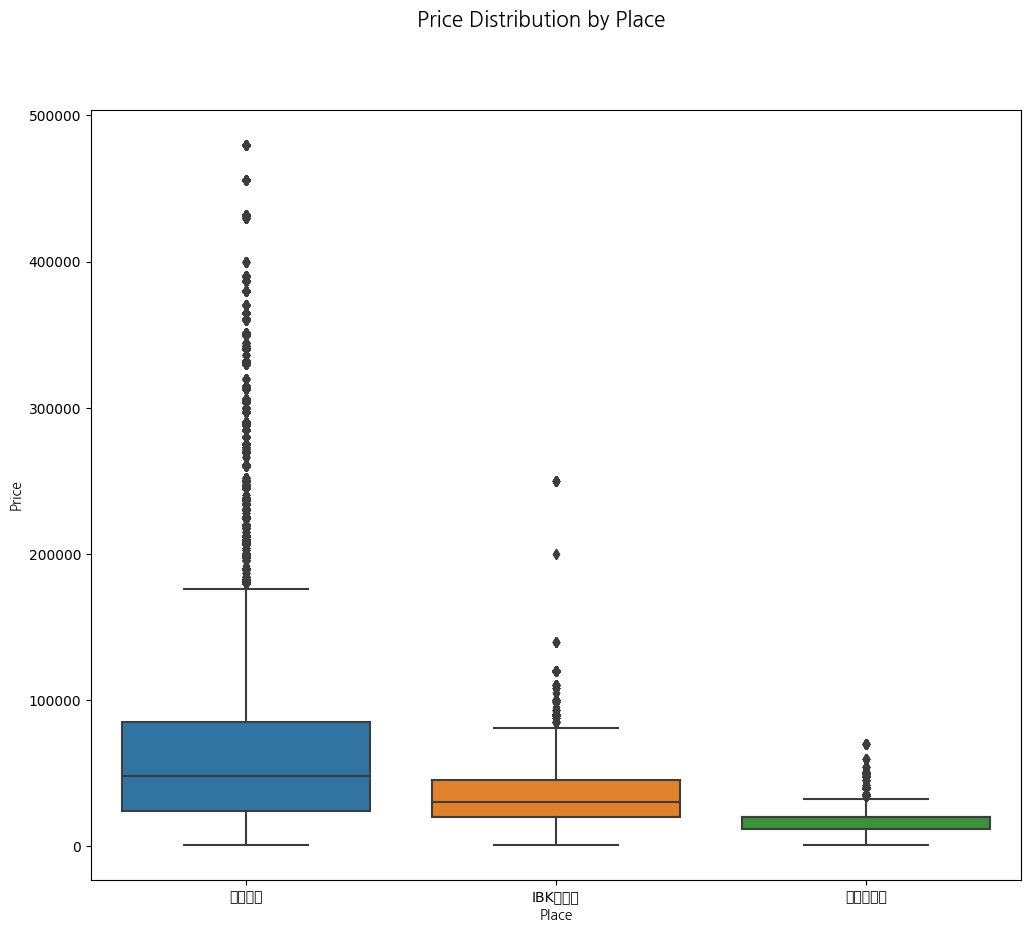

In [34]:
# 필요한 데이터 추출 (콘서트홀, 리사이틀홀, IBK챔버홀에 해당하는 데이터만 필터링)
filtered_data = data_for_eda[data_for_eda['place'].isin(['콘서트홀', '리사이틀홀', 'IBK챔버홀'])]
# 가격이 0보다 큰 데이터 선택
filtered_data_nonzero = filtered_data[filtered_data['price'] > 0]

# 1x1 서브플롯 생성 (1행 1열의 서브플롯)
fig, ax = plt.subplots(figsize=(12, 10))
fig.suptitle('Price Distribution by Place', fontsize=15, fontproperties=font_prop)

# 가격에 대한 박스플롯
sns.boxplot(data=filtered_data_nonzero, x='place', y='price', ax=ax)
ax.set_xlabel('Place', fontproperties=font_prop)
ax.set_ylabel('Price', fontproperties=font_prop)

# 그래프 표시
plt.show()

# 3. 결제 방식에 따른 좌석 군집화

## 3.1 콘서트홀 데이터 분석

### 콘서트홀의 데이터 추출 & 결측치 확인

In [35]:
# place 열에서 "콘서트홀" 데이터 추출
concert_data = data[data['place'] == '콘서트홀']

In [36]:
concert_data

,age,gender,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,membership_type_6,tran_date,tran_time,play_date,play_st_time,seat,price,ticket_cancel,discount_type,performance_code,pre_open_date,open_date,genre,place,running_time,intermission,member_yn
0,50.0,F,골드,무료,그린,NaN,NaN,NaN,20220114,1512,20220204,2000,3층 BOX9 10,10000,2,일반,302,20220114.0,20220115.0,교향곡,콘서트홀,120,15,Y
4,50.0,M,무료,NaN,NaN,NaN,NaN,NaN,20220206,1615,20220302,1930,1층 B블록12열 7,180000,0,일반,897,20220109.0,20220110.0,독주,콘서트홀,90,0,Y
5,30.0,F,블루,무료,NaN,NaN,NaN,NaN,20181124,1145,20190323,2000,1층 A블록2열 1,144000,2,블루회원 할인20%,528,20181119.0,20181119.0,교향곡,콘서트홀,100,15,Y
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20191020,1459,20191109,1700,3층 E블록4열 8,0,0,초대권,44,NaN,20191023.0,교향곡,콘서트홀,100,15,N
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20190613,954,20190723,2000,2층 D블록8열 4,0,0,초대권,827,20190602.0,20190602.0,교향곡,콘서트홀,120,20,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920853,60.0,F,무료,그린,NaN,NaN,NaN,NaN,20210618,1509,20210704,1500,1층 A블록2열 2,90000,2,일반,887,20210618.0,20210620.0,교향곡,콘서트홀,110,20,Y
1920855,50.0,M,무료,NaN,NaN,NaN,NaN,NaN,20230522,1729,20230613,1700,3층 A블록6열 4,10000,0,일반,2825,20230505.0,20230507.0,교향곡,콘서트홀,120,15,Y
1920856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20201009,1652,20201020,1930,1층 D블록16열 12,0,0,초대권,77,NaN,20200920.0,클래식,콘서트홀,120,15,N
1920858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20200726,1655,20200818,1930,1층 D블록20열 8,0,0,기획사판매,850,20200719.0,20200720.0,합창,콘서트홀,110,15,N


In [37]:
# 결측치 변수 확인
missing_val = concert_data.isnull().sum()
total_samples = len(concert_data)

missing_ratio = (missing_val / total_samples) * 100

missing_info = pd.DataFrame({
    'Column': missing_val.index,
    'Missing Count': missing_val.values,
    'Missing Ratio (%)': missing_ratio.values
})

print(missing_info)

               Column  Missing Count  Missing Ratio (%)
0                 age         612451          55.831255
1              gender         612101          55.799349
2   membership_type_1         612101          55.799349
3   membership_type_2         707231          64.471434
4   membership_type_3         956500          87.194886
5   membership_type_4        1071808          97.706405
6   membership_type_5        1095858          99.898812
7   membership_type_6        1096968         100.000000
8           tran_date              0           0.000000
9           tran_time              0           0.000000
10          play_date              0           0.000000
11       play_st_time              0           0.000000
12               seat              0           0.000000
13              price              0           0.000000
14      ticket_cancel              0           0.000000
15      discount_type              0           0.000000
16   performance_code              0           0

### 콘서트홀 데이터 시각화

In [38]:
concert_for_eda = concert_data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


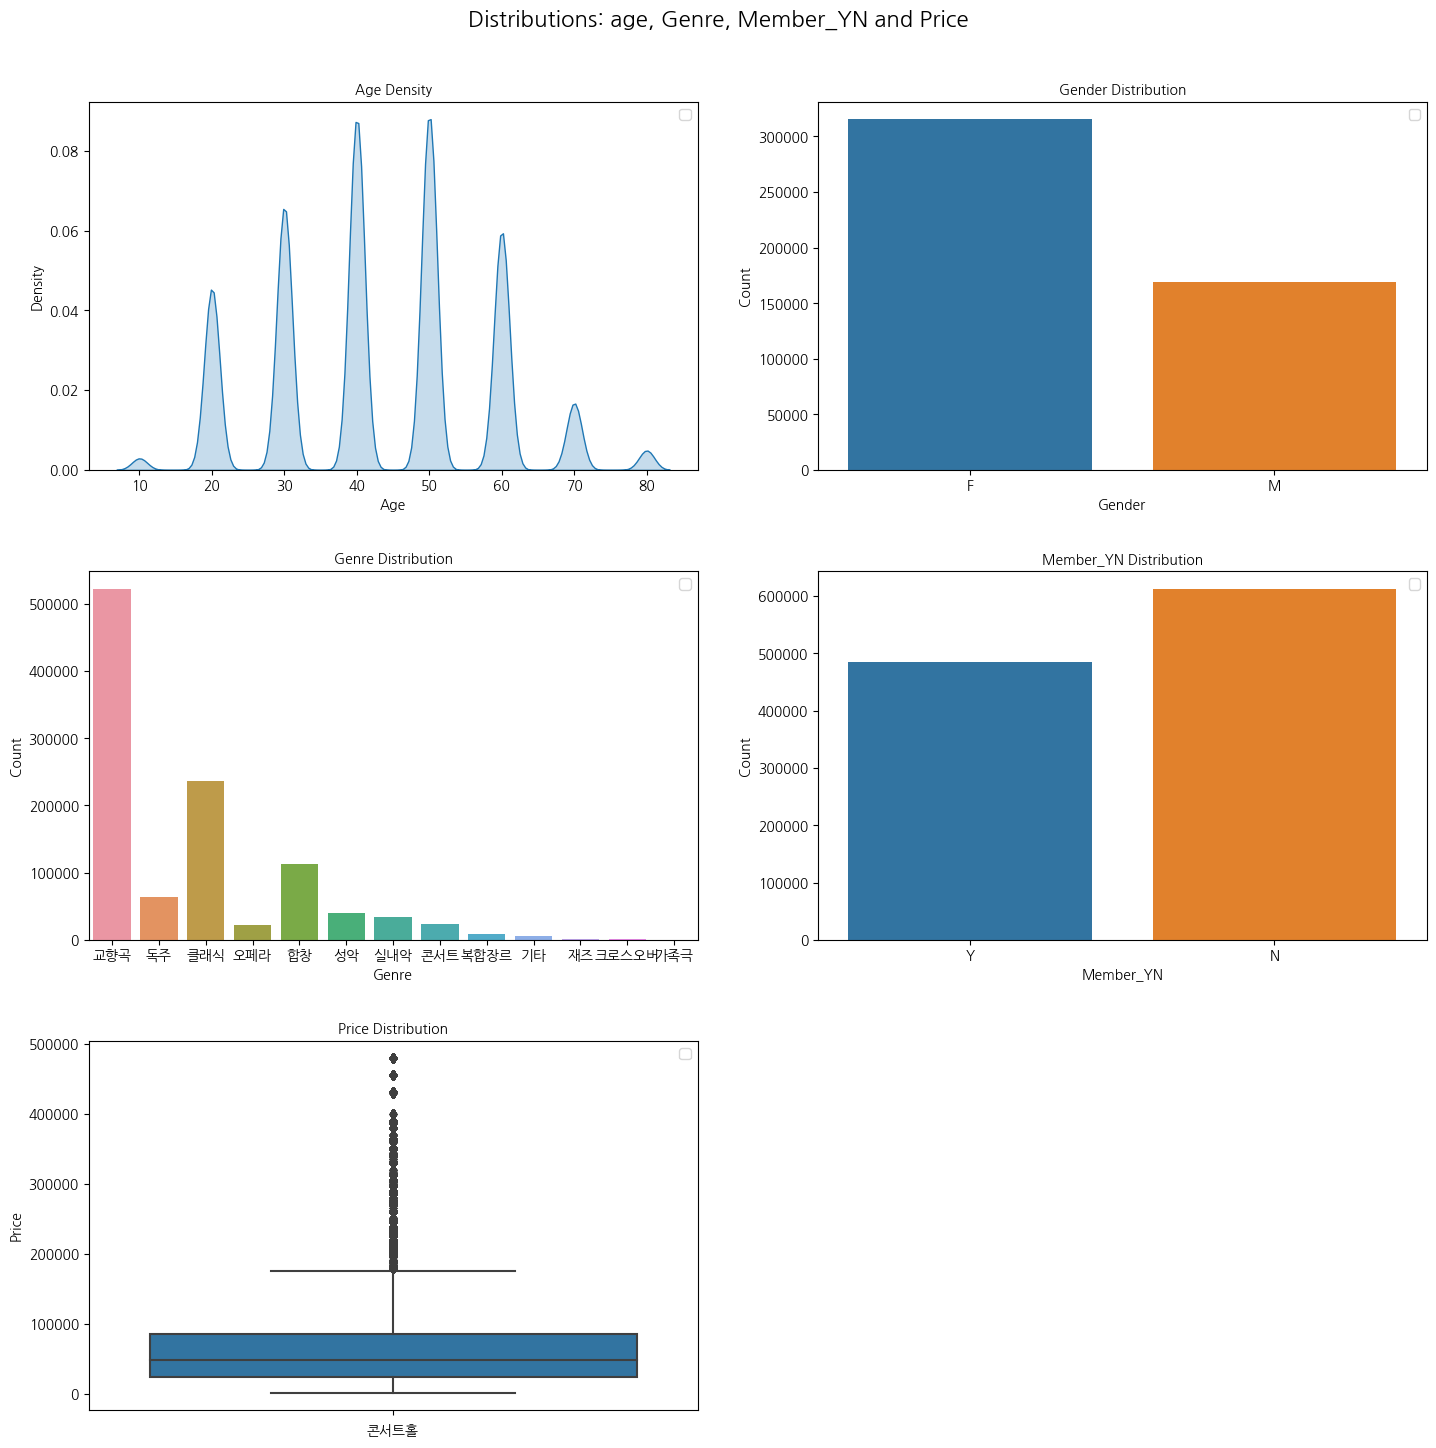

In [39]:
# 3x2 서브플롯 생성
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Distributions: age, Genre, Member_YN and Price', fontsize=16, fontproperties=font_prop)

# age에 대한 밀도플롯
sns.kdeplot(data=concert_for_eda, x='age', ax=axes[0, 0], fill=True)
axes[0, 0].set_title('Age Density', fontproperties=font_prop)
axes[0, 0].set_xlabel('Age', fontproperties=font_prop)
axes[0, 0].set_ylabel('Density', fontproperties=font_prop)

# Gender에 대한 히스토그램
sns.countplot(data=concert_for_eda, x='gender', ax=axes[0, 1])
axes[0, 1].set_title('Gender Distribution', fontproperties=font_prop)
axes[0, 1].set_xlabel('Gender', fontproperties=font_prop)
axes[0, 1].set_ylabel('Count', fontproperties=font_prop)

# Genre에 대한 히스토그램
sns.countplot(data=concert_for_eda, x='genre', ax=axes[1, 0])
axes[1, 0].set_title('Genre Distribution', fontproperties=font_prop)
axes[1, 0].set_xlabel('Genre', fontproperties=font_prop)
axes[1, 0].set_ylabel('Count', fontproperties=font_prop)

# Member_YN에 대한 히스토그램
sns.countplot(data=concert_for_eda, x='member_yn', ax=axes[1, 1])
axes[1, 1].set_title('Member_YN Distribution', fontproperties=font_prop)
axes[1, 1].set_xlabel('Member_YN', fontproperties=font_prop)
axes[1, 1].set_ylabel('Count', fontproperties=font_prop)

# Price에 대한 박스플롯
sns.boxplot(data=concert_for_eda[concert_for_eda['price'] > 0], y='price', ax=axes[2, 0])
axes[2, 0].set_title('Price Distribution', fontproperties=font_prop)
axes[2, 0].set_xlabel('콘서트홀', fontproperties=font_prop)
axes[2, 0].set_ylabel('Price', fontproperties=font_prop)

# X축 레이블 글자 크기 줄이기
for ax in axes.flat:
    ax.tick_params(axis='x', labelsize=8)

# 불필요한 서브플롯 제거
fig.delaxes(axes[2, 1])

# 한글 폰트 적용
for ax in axes.flat:
    # legend 한글 폰트 설정
    legend = ax.legend()
    for text in legend.get_texts():
        text.set_fontproperties(font_prop) 
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(font_prop)


# 그래프 간 간격 조절
plt.tight_layout(pad=3.0)

# 그래프 표시
plt.show()

### 퍼포먼스 코드와 장르 연관성 확인

In [40]:
# 퍼포먼스 코드가 같으면 같은 장르를 갖는지 확인해 보자. -> 장르와 퍼포먼스 코드 연관성 찾기
grouped = concert_data.groupby('performance_code')['genre'].unique()

In [41]:
# performance code는 같은데 다른 genre 값을 가지는 경우
grouped[grouped.apply(len) > 1]

performance_code
7       [클래식, 교향곡]
229     [nan, 교향곡]
646     [클래식, 교향곡]
863     [교향곡, 클래식]
1496    [교향곡, 클래식]
1863     [합창, 교향곡]
2046    [교향곡, 클래식]
2215    [클래식, nan]
2839    [클래식, 오페라]
Name: genre, dtype: object

## 3.2 콘서트홀 좌석 기반 데이터 프레임 생성1 - 파생변수 만들기

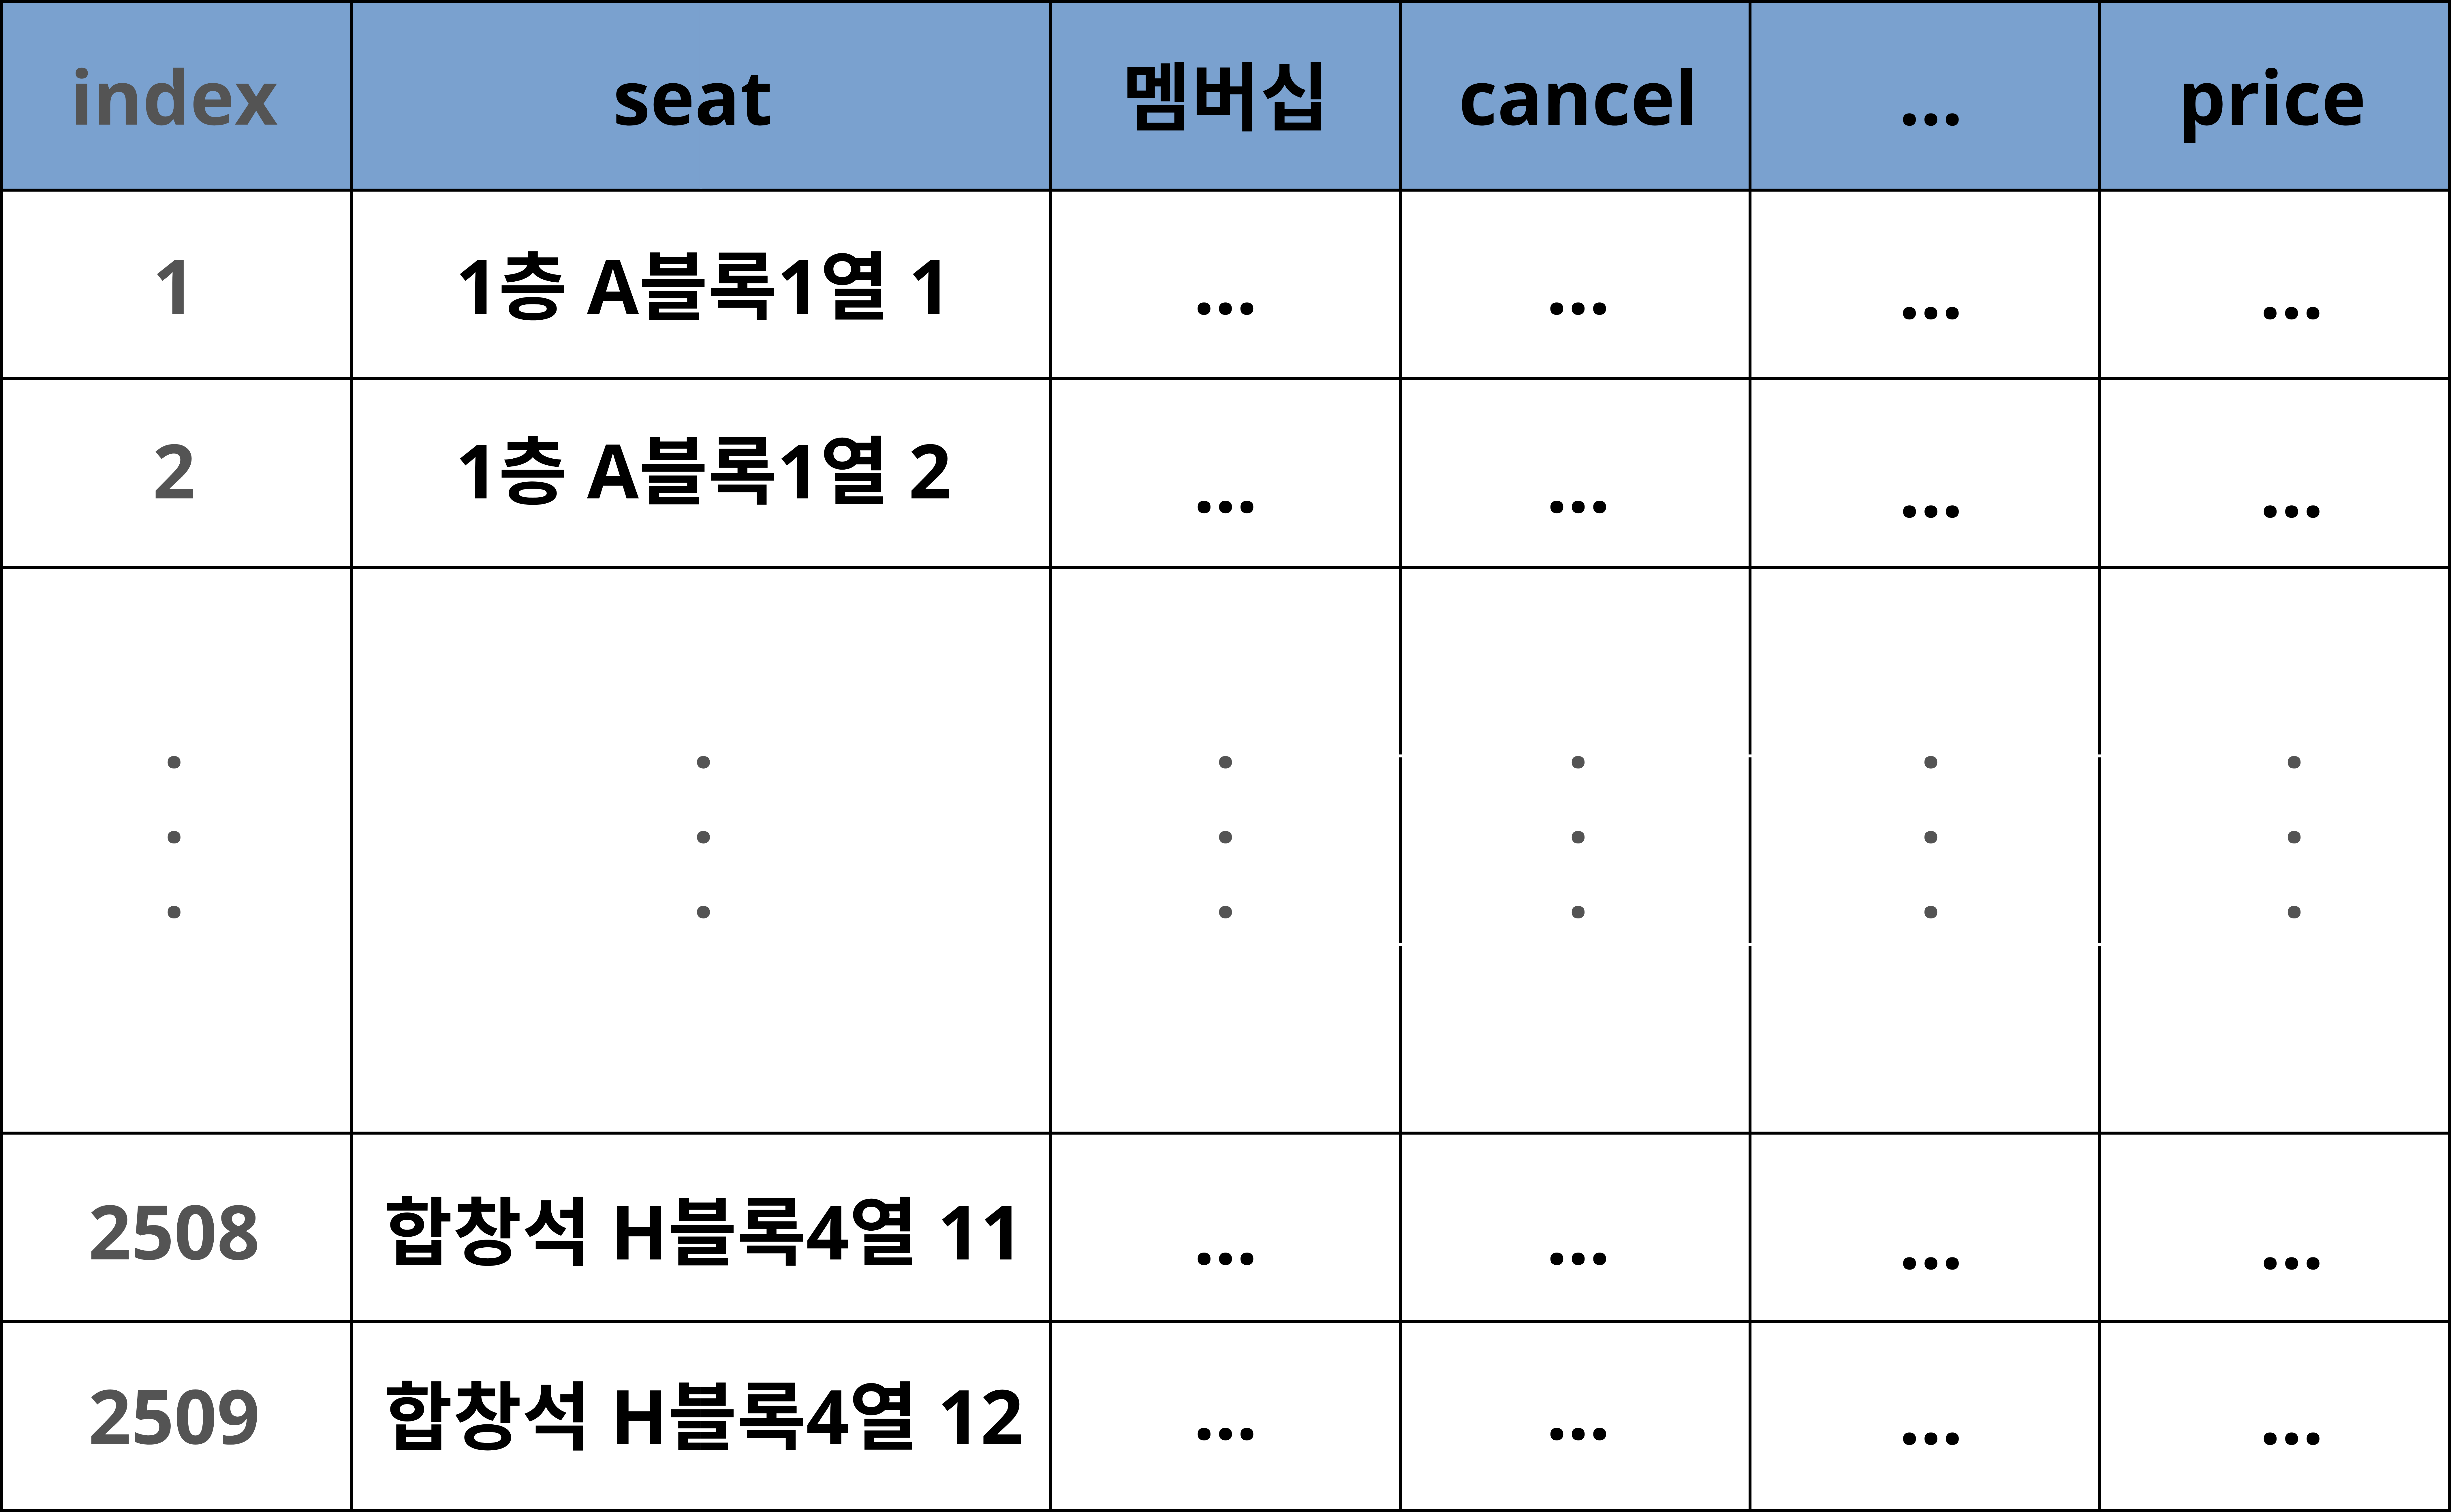

### - [콘서트홀 좌석 기반 데이터 프레임 모식도]

In [42]:
display(Image("./table.png", width=600, height=400))
Markdown("### - [콘서트홀 좌석 기반 데이터 프레임 모식도]")

### 멤버십 변수 정리

In [43]:
# membership_type_6 변수는 모두 결측 -> 제거
concert_data = concert_data.drop(columns=['membership_type_6'])

In [44]:
membership_types = ['골드', '무료', '그린', '싹틔우미', '블루', '노블']
for membership_type in membership_types:
    concert_data[membership_type] = concert_data.apply(lambda row: 1 if membership_type in row.values else 0, axis=1)

In [45]:
concert_data

,age,gender,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,tran_date,tran_time,play_date,play_st_time,seat,price,ticket_cancel,discount_type,performance_code,pre_open_date,open_date,genre,place,running_time,intermission,member_yn,골드,무료,그린,싹틔우미,블루,노블
0,50.0,F,골드,무료,그린,NaN,NaN,20220114,1512,20220204,2000,3층 BOX9 10,10000,2,일반,302,20220114.0,20220115.0,교향곡,콘서트홀,120,15,Y,1,1,1,0,0,0
4,50.0,M,무료,NaN,NaN,NaN,NaN,20220206,1615,20220302,1930,1층 B블록12열 7,180000,0,일반,897,20220109.0,20220110.0,독주,콘서트홀,90,0,Y,0,1,0,0,0,0
5,30.0,F,블루,무료,NaN,NaN,NaN,20181124,1145,20190323,2000,1층 A블록2열 1,144000,2,블루회원 할인20%,528,20181119.0,20181119.0,교향곡,콘서트홀,100,15,Y,0,1,0,0,1,0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20191020,1459,20191109,1700,3층 E블록4열 8,0,0,초대권,44,NaN,20191023.0,교향곡,콘서트홀,100,15,N,0,0,0,0,0,0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20190613,954,20190723,2000,2층 D블록8열 4,0,0,초대권,827,20190602.0,20190602.0,교향곡,콘서트홀,120,20,N,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920853,60.0,F,무료,그린,NaN,NaN,NaN,20210618,1509,20210704,1500,1층 A블록2열 2,90000,2,일반,887,20210618.0,20210620.0,교향곡,콘서트홀,110,20,Y,0,1,1,0,0,0
1920855,50.0,M,무료,NaN,NaN,NaN,NaN,20230522,1729,20230613,1700,3층 A블록6열 4,10000,0,일반,2825,20230505.0,20230507.0,교향곡,콘서트홀,120,15,Y,0,1,0,0,0,0
1920856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20201009,1652,20201020,1930,1층 D블록16열 12,0,0,초대권,77,NaN,20200920.0,클래식,콘서트홀,120,15,N,0,0,0,0,0,0
1920858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20200726,1655,20200818,1930,1층 D블록20열 8,0,0,기획사판매,850,20200719.0,20200720.0,합창,콘서트홀,110,15,N,0,0,0,0,0,0


### 예매 변수 만들기 (예매일자 - 결제일자)

> 음수 값은 얼리버드 예매자

In [46]:
concert_data['open_date'] = pd.to_datetime(concert_data['open_date'], format='%Y%m%d')
concert_data['tran_date'] = pd.to_datetime(concert_data['tran_date'], format='%Y%m%d')

concert_data['date_diff'] = (concert_data['open_date'] - concert_data['tran_date']).dt.days
# 이때 0 미만의 값이 발생하는 건 전부 선예매라고 간주 - 얼리버드 예매자

### 할인율 변수 만들기

> 할인표 수나 공짜표 수는 총 예매수와 상관성이 있기에 평균 할인율 변수를 계산함.

In [47]:
import re
def extract_discount(text):
    match = re.search(r'(\d+)%', text)
    if match:
        return int(match.group(1))  # 숫자만 추출하여 정수로 변환
    else:
        return None

# '할인율' 칼럼 추가
concert_data['할인율'] = concert_data['discount_type'].apply(extract_discount)

In [48]:
# price가 0인 행의 '할인율'이 None인 경우에 100으로 설정
concert_data.loc[(concert_data['price'] == 0) & (concert_data['할인율'].isna()), '할인율'] = 100

In [49]:
concert_data['할인율'].value_counts()

할인율
100.0    579246
10.0      85857
5.0       50938
20.0      50684
30.0      47241
50.0      46656
40.0      29627
15.0      16205
25.0       2340
12.0       1104
60.0        234
75.0         39
35.0         28
80.0         27
Name: count, dtype: int64

In [50]:
# 당일 할인 티켓: 3만원 초과는 모두 1만원, 3만원 이하는 모두 5천원 -> 할인율 계산이 불가하여 가장 근사한 80%로 선택 
# 일만원의 나눔 / 이만원의 기쁨 / 삼만원의 행복 / 오만원의 사랑: S석 10만원인데 개인 의사에 따라 최대 90% 할인율 적용해 자율적 구매 가능했음.
# 90% 할인 /       80% 할인 /    70% 할인      /  50% 할인 
# 초중고: 50% 할인 
# 대학: 30% 할인
concert_data.loc[concert_data['discount_type'] == '일만원의 나눔', '할인율'] = 90
concert_data.loc[concert_data['discount_type'] == '이만원의 기쁨', '할인율'] = 80
concert_data.loc[concert_data['discount_type'] == '삼만원의 행복', '할인율'] = 70
concert_data.loc[concert_data['discount_type'] == '오만원의 사랑', '할인율'] = 50

concert_data.loc[concert_data['discount_type'] == '초/중/고등학생 할인(본인만)', '할인율'] = 50
concert_data.loc[concert_data['discount_type'] == '초/중/고등학생 할인', '할인율'] = 50

concert_data.loc[concert_data['discount_type'] == '초/중/고/대학생 할인(본인만)', '할인율'] = 30

concert_data.loc[concert_data['discount_type'] == '당일할인티켓', '할인율'] = 80
concert_data.loc[concert_data['discount_type'] == '당일할인티켓_', '할인율'] = 80

concert_data.loc[concert_data['discount_type'] == '일반', '할인율'] = 0
concert_data.loc[concert_data['discount_type'] == '차액', '할인율'] = 0

concert_data.loc[concert_data['discount_type'] == '공연예매권', '할인율'] = 100

concert_data.loc[concert_data['discount_type'] == '싹틔우미 할인', '할인율'] = 40

In [51]:
concert_data[concert_data['할인율'].isna()]['discount_type'].value_counts()

discount_type
기획사할인                  444
특판B                     65
블랙프라이데이 이벤트             31
골드회원+음반패키지              27
2+1 특별할인                24
수험생 할인(동반1인)            21
특별할인(2+1)               18
공연진행석                   16
하비에르 국제학교 학부모, 직원       15
골드회원+음반 패키지             13
A석+호두까기인형 패키지           12
도서 인증 A                 11
골드회원 할인+음반패키지           10
특판A                      9
하비에르 국제학교 재학생            9
S석+호두까기인형 패키지            8
특판D                      7
초/중/고/대학생(본인)+음반패키지      7
도서 인증 S                  6
노르웨이의 숲 도서 인증 할인         6
기획사                      6
초대권                      1
Name: count, dtype: int64

In [52]:
# 위의 discount_type에 해당하는, 할인율이 모호한 데이터들은 전체 데이터셋의 0.07% 밖에 안 되기 때문에 삭제해준다.
concert_data = concert_data.dropna(subset=['할인율'])

In [53]:
concert_data

,age,gender,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,tran_date,tran_time,play_date,play_st_time,seat,price,ticket_cancel,discount_type,performance_code,pre_open_date,open_date,genre,place,running_time,intermission,member_yn,골드,무료,그린,싹틔우미,블루,노블,date_diff,할인율
0,50.0,F,골드,무료,그린,NaN,NaN,2022-01-14,1512,20220204,2000,3층 BOX9 10,10000,2,일반,302,20220114.0,2022-01-15,교향곡,콘서트홀,120,15,Y,1,1,1,0,0,0,1,0.0
4,50.0,M,무료,NaN,NaN,NaN,NaN,2022-02-06,1615,20220302,1930,1층 B블록12열 7,180000,0,일반,897,20220109.0,2022-01-10,독주,콘서트홀,90,0,Y,0,1,0,0,0,0,-27,0.0
5,30.0,F,블루,무료,NaN,NaN,NaN,2018-11-24,1145,20190323,2000,1층 A블록2열 1,144000,2,블루회원 할인20%,528,20181119.0,2018-11-19,교향곡,콘서트홀,100,15,Y,0,1,0,0,1,0,-5,20.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-20,1459,20191109,1700,3층 E블록4열 8,0,0,초대권,44,NaN,2019-10-23,교향곡,콘서트홀,100,15,N,0,0,0,0,0,0,3,100.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-13,954,20190723,2000,2층 D블록8열 4,0,0,초대권,827,20190602.0,2019-06-02,교향곡,콘서트홀,120,20,N,0,0,0,0,0,0,-11,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920853,60.0,F,무료,그린,NaN,NaN,NaN,2021-06-18,1509,20210704,1500,1층 A블록2열 2,90000,2,일반,887,20210618.0,2021-06-20,교향곡,콘서트홀,110,20,Y,0,1,1,0,0,0,2,0.0
1920855,50.0,M,무료,NaN,NaN,NaN,NaN,2023-05-22,1729,20230613,1700,3층 A블록6열 4,10000,0,일반,2825,20230505.0,2023-05-07,교향곡,콘서트홀,120,15,Y,0,1,0,0,0,0,-15,0.0
1920856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-09,1652,20201020,1930,1층 D블록16열 12,0,0,초대권,77,NaN,2020-09-20,클래식,콘서트홀,120,15,N,0,0,0,0,0,0,-19,100.0
1920858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-26,1655,20200818,1930,1층 D블록20열 8,0,0,기획사판매,850,20200719.0,2020-07-20,합창,콘서트홀,110,15,N,0,0,0,0,0,0,-6,100.0


## 3.3 콘서트홀 좌석 기반 데이터 프레임 생성2 - 데이터 프레임 만들기

>좌석별 군집화를 하기 위해선 좌석별 특성을 가지고 군집화를 해야 함.<br>
따라서 seat 열을 기준으로 groupby 해주고, 각 좌석 특성에 관한 변수들. 즉, 앞서 만들어 놓은 변수들을 이용하여 데이터 프레임을 생성함.

In [54]:
# 좌석 특성에 관한 변수 추출
selected_columns = ['seat', 'price', 'ticket_cancel', '골드', '무료', '그린', '싹틔우미', '블루', '노블', 'date_diff', '할인율']
cseat_data = concert_data[selected_columns]

# 행 간 분산을 맞추기 위한 value 열 추가
cseat_data['value'] = 1

In [55]:
# 티켓 취소 열 전처리
cseat_data['ticket_cancel'] = cseat_data['ticket_cancel']/2

In [56]:
cseat_data

,seat,price,ticket_cancel,골드,무료,그린,싹틔우미,블루,노블,date_diff,할인율,value
0,3층 BOX9 10,10000,1.0,1,1,1,0,0,0,1,0.0,1
4,1층 B블록12열 7,180000,0.0,0,1,0,0,0,0,-27,0.0,1
5,1층 A블록2열 1,144000,1.0,0,1,0,0,1,0,-5,20.0,1
6,3층 E블록4열 8,0,0.0,0,0,0,0,0,0,3,100.0,1
7,2층 D블록8열 4,0,0.0,0,0,0,0,0,0,-11,100.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1920853,1층 A블록2열 2,90000,1.0,0,1,1,0,0,0,2,0.0,1
1920855,3층 A블록6열 4,10000,0.0,0,1,0,0,0,0,-15,0.0,1
1920856,1층 D블록16열 12,0,0.0,0,0,0,0,0,0,-19,100.0,1
1920858,1층 D블록20열 8,0,0.0,0,0,0,0,0,0,-6,100.0,1


In [57]:
# 좌석 열 기준 group_by
cseat_data = cseat_data.groupby('seat').agg({
    'price': 'sum',
    'ticket_cancel': 'sum',
    '골드': 'sum',
    '무료': 'sum',
    '그린': 'sum',
    '싹틔우미': 'sum',
    '블루': 'sum',
    '노블': 'sum',
    'date_diff': 'sum',
    '할인율': 'sum',
    'value' : 'sum',
}).reset_index()

In [58]:
# 좌석 간 (행 간) 분포 맞추기 
columns_to_divide = [col for col in cseat_data.columns if col not in ['seat', 'value']]

cseat_data[columns_to_divide] = cseat_data[columns_to_divide].div(cseat_data['value'], axis=0)
cseat_data = cseat_data.drop('value', axis=1) # value열 삭제
cseat_data

,seat,price,ticket_cancel,골드,무료,그린,싹틔우미,블루,노블,date_diff,할인율
0,1층 A블록10열 1,22438.692098,0.163488,0.106267,0.318801,0.062670,0.049046,0.068120,0.019074,-29.065395,69.945504
1,1층 A블록10열 10,32837.168142,0.191150,0.145133,0.396460,0.118584,0.046018,0.111504,0.019469,-23.930973,66.584071
2,1층 A블록10열 11,36233.333333,0.209259,0.174074,0.448148,0.125926,0.051852,0.129630,0.033333,-24.925926,63.796296
3,1층 A블록10열 2,18582.089552,0.141791,0.106965,0.286070,0.062189,0.037313,0.062189,0.017413,-26.674129,73.370647
4,1층 A블록10열 3,18198.391421,0.120643,0.101877,0.268097,0.053619,0.045576,0.058981,0.024129,-28.450402,73.686327
...,...,...,...,...,...,...,...,...,...,...,...
2504,합창석 H블록4열 5,36014.354067,0.301435,0.287081,0.636364,0.224880,0.095694,0.224880,0.071770,-23.363636,41.684211
2505,합창석 H블록4열 6,32352.657005,0.280193,0.173913,0.565217,0.217391,0.111111,0.173913,0.038647,-24.816425,43.971014
2506,합창석 H블록4열 7,40881.443299,0.304124,0.201031,0.618557,0.309278,0.123711,0.170103,0.036082,-20.288660,41.340206
2507,합창석 H블록4열 8,34852.678571,0.330357,0.294643,0.633929,0.258929,0.111607,0.263393,0.035714,-24.468750,43.750000


In [59]:
# 통계량 확인하기
cseat_data.describe()

,price,ticket_cancel,골드,무료,그린,싹틔우미,블루,노블,date_diff,할인율
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,29146.929804,0.212931,0.170634,0.446853,0.136965,0.072140,0.114337,0.015653,-24.585644,58.939140
std,9753.678881,0.067258,0.077629,0.152394,0.072601,0.033966,0.056166,0.011820,5.243526,14.415479
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-115.125000,0.000000
25%,22059.602649,0.161220,0.112150,0.324706,0.081498,0.045752,0.071298,0.008547,-27.073009,45.273109
50%,28026.881720,0.206383,0.163265,0.435685,0.121157,0.067500,0.105140,0.013015,-24.571705,61.845124
75%,34722.916667,0.263852,0.215247,0.581109,0.177620,0.094907,0.151899,0.019417,-21.886598,70.861423
max,72479.041916,0.413559,0.479930,0.770642,0.435606,0.219626,0.339463,0.128920,12.440678,100.000000


## 3.4 새로운 데이터 프레임 기반 군집화

### 변수 간 선형성 확인을 위한 상관관계 분석

In [60]:
data_for_cor = cseat_data.copy()

In [61]:
# seat 열 제거
data_for_cor = data_for_cor.drop('seat', axis=1)

In [62]:
# 데이터 scaling
scaler = StandardScaler() # 변수 간 평균 및 분산을 맞추기 위해
scaled_data = scaler.fit_transform(data_for_cor)
scaled_data

array([[-0.68790197, -0.73528149, -0.82932961, ...,  0.28947731,
        -0.85450972,  0.76366231],
       [ 0.37841865, -0.32390452, -0.32856926, ...,  0.3229417 ,
         0.12487797,  0.53043361],
       [ 0.72668131, -0.0546051 ,  0.04432163, ...,  1.4961677 ,
        -0.06490859,  0.33700749],
       ...,
       [ 1.20332572,  1.35614095,  0.39164379, ...,  1.72880562,
         0.819647  , -1.22107926],
       [ 0.58510089,  1.74626295,  1.59777478, ...,  1.69764876,
         0.02229743, -1.05387884],
       [ 0.89112622,  1.27865219,  1.51274593, ...,  4.65416432,
         0.66633572, -0.97959302]])

In [63]:
# scaled_data -> df로 변환
scaled_data_frame = pd.DataFrame(scaled_data, columns=data_for_cor.columns)

In [64]:
# 상관계수 계산
cor = scaled_data_frame.corr()
cor.values

array([[ 1.        ,  0.49408799,  0.65742984,  0.39531661,  0.51856636,
         0.15239665,  0.49173031,  0.40184487,  0.41953179, -0.24111937],
       [ 0.49408799,  1.        ,  0.83533167,  0.923845  ,  0.88527952,
         0.65984063,  0.85526414,  0.47042236,  0.45153296, -0.81546088],
       [ 0.65742984,  0.83533167,  1.        ,  0.80090073,  0.82171841,
         0.44132007,  0.85281959,  0.58958978,  0.54621814, -0.62535134],
       [ 0.39531661,  0.923845  ,  0.80090073,  1.        ,  0.87329926,
         0.75754105,  0.87405648,  0.44499874,  0.37264086, -0.88727608],
       [ 0.51856636,  0.88527952,  0.82171841,  0.87329926,  1.        ,
         0.64856433,  0.87244185,  0.51671525,  0.41692844, -0.77509516],
       [ 0.15239665,  0.65984063,  0.44132007,  0.75754105,  0.64856433,
         1.        ,  0.60925851,  0.13382939,  0.20838717, -0.70001793],
       [ 0.49173031,  0.85526414,  0.85281959,  0.87405648,  0.87244185,
         0.60925851,  1.        ,  0.5171645 

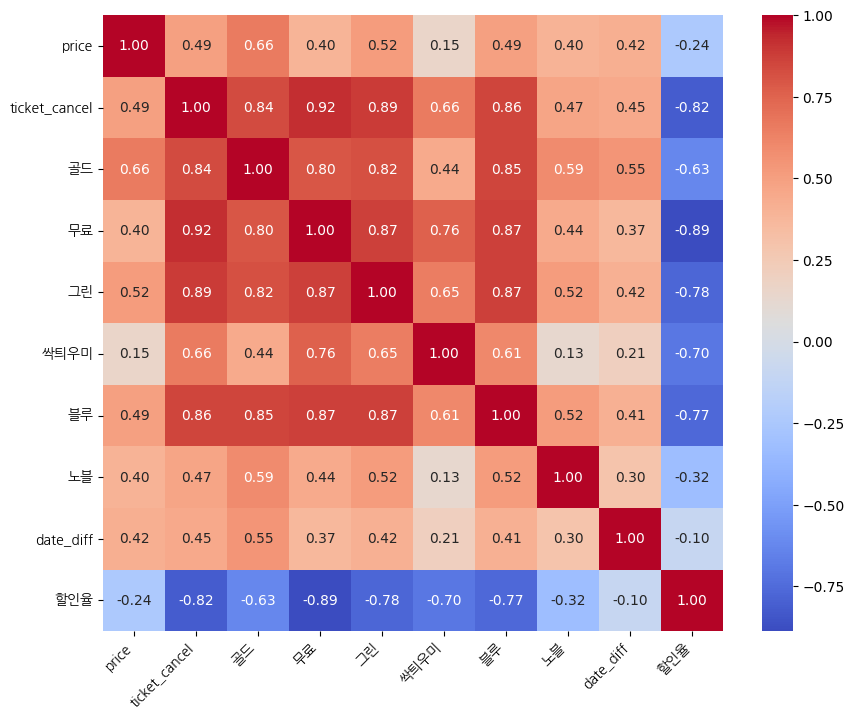

In [65]:
# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cor, annot=True, fmt=".2f", cmap="coolwarm")

plt.xticks(fontproperties=font_prop, rotation=45, ha="right")
plt.yticks(fontproperties=font_prop)

plt.show()

### 차원 축소 - 주성분 분석 (PCA)

> 주성분 개수 설정을 위한 scree plot 그리기

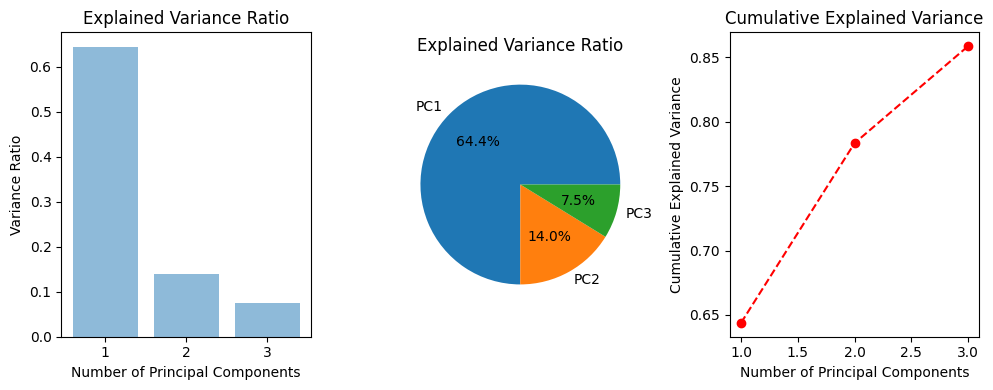

In [66]:
# PCA 모델 생성
n_components = 3
pca = PCA(n_components=n_components)

# PCA 수행
principal_components = pca.fit_transform(scaled_data)

# 주성분 개수에 따른 설명된 분산의 비율
explained_variance_ratio = pca.explained_variance_ratio_

# 누적 설명된 분산 계산
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Scree plot 그리기
plt.figure(figsize=(10, 4))

# 설명된 분산의 비율 - bar plot
plt.subplot(1, 3, 1)
plt.bar(range(1, n_components + 1), explained_variance_ratio, align='center', alpha=0.5)
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Ratio')
plt.title('Explained Variance Ratio')

# 설명된 분산의 비율 - Pie chart
plt.subplot(1, 3, 2)
plt.pie(explained_variance_ratio, labels=['PC1', 'PC2', 'PC3'], autopct=lambda p: '{:.1f}%'.format(p * sum(explained_variance_ratio)))
plt.title('Explained Variance Ratio')

# 누적 설명된 분산
plt.subplot(1, 3, 3)
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='--', color='r')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')

plt.tight_layout()
plt.show()


> PCA 모델 설정

In [67]:
# PCA 모델 생성
n_components = 2  # 주성분의 개수를 2로 설정 
pca = PCA(n_components=n_components)

# PCA 수행
principal_components = pca.fit_transform(scaled_data)

ratio = pca.explained_variance_ratio_

ratio

array([0.64387635, 0.13952533])

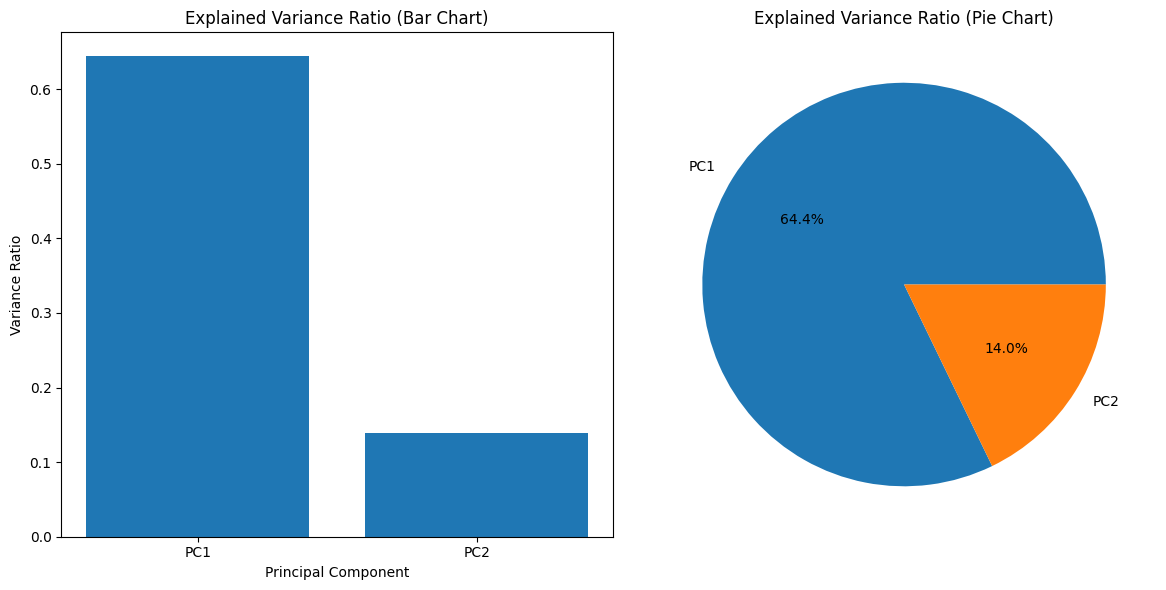

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Bar chart
axs[0].bar(['PC1', 'PC2'], ratio)
axs[0].set_ylabel('Variance Ratio')
axs[0].set_xlabel('Principal Component')
axs[0].set_title('Explained Variance Ratio (Bar Chart)')

# Pie chart
axs[1].pie(ratio, labels=['PC1', 'PC2'], autopct=lambda p: '{:.1f}%'.format(p * sum(ratio)))
axs[1].set_title('Explained Variance Ratio (Pie Chart)')

plt.tight_layout()
plt.show()

### 군집화 - K-Means

> 함수 정의

In [69]:
### 여러개의 군집 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  
def visualize_silhouette(cluster_lists, X_features): 
    
    # 입력값으로 군집 갯수들을 리스트로 받아서, 각 갯수별로 군집화 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 군집 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 군집 결과 저장
    all_cluster_labels = []
    
    # 리스트에 기재된 군집 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 군집화를 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        all_cluster_labels.append(cluster_labels) # 군집 결과 저장
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 군집 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
    return all_cluster_labels

In [70]:
def visualize_kmeans_plot_multi(cluster_lists, X_features, cluster_labels):
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    dataframe = pd.DataFrame(X_features, columns=['PCA1', 'PCA2'])

    for ind, n_cluster in enumerate(cluster_lists):
        # KMeans 클러스터링으로 군집화 결과를 dataframe에 저장.
        dataframe['cluster'] = cluster_labels[ind]

        unique_labels = np.unique(cluster_labels[ind])
        markers = ['o', 's', '^', 'x', '*']

        for label in unique_labels:
            label_df = dataframe[dataframe['cluster'] == label]
            if label == -1:
                cluster_legend = 'Noise'
            else:
                cluster_legend = 'Cluster ' + str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,
                            edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster: ' + str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

> 군집화 및 시각화

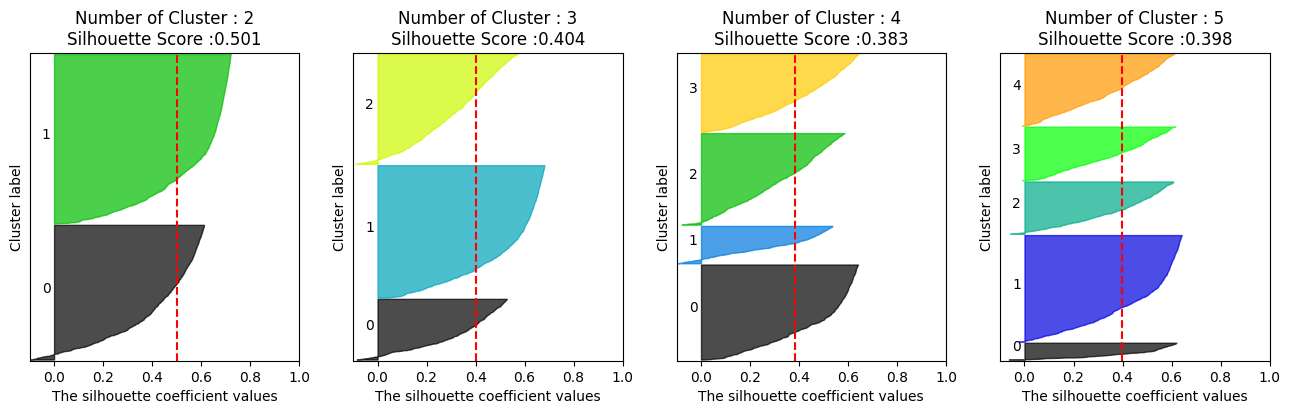

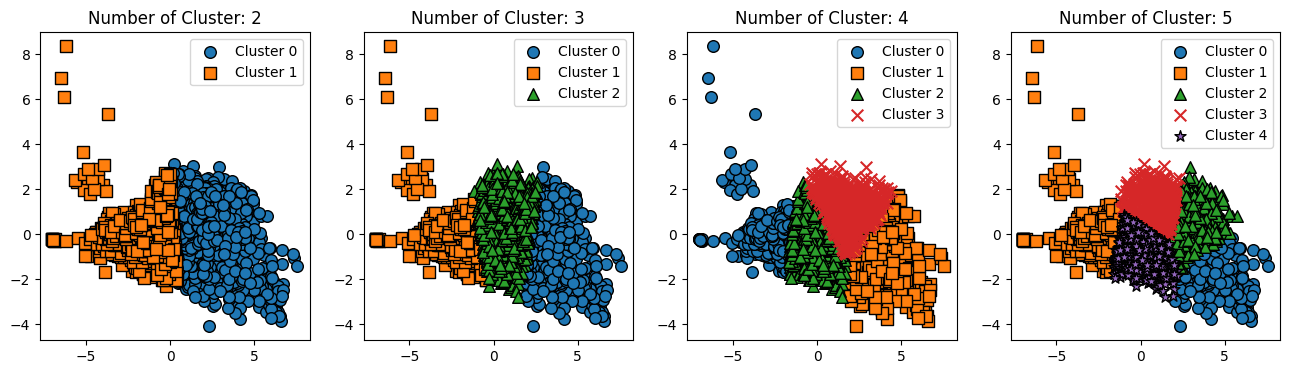

In [71]:
# 군집화 및 시각화
labels_list = visualize_silhouette([2,3,4,5], principal_components)
visualize_kmeans_plot_multi([2,3,4,5],principal_components, labels_list)

> 최적의 군집 개수를 결정하기 위한 Elbow point 그래프

In [72]:
# elbow point 그리는 함수
def visualize_inertia(cluster_lists, X_features):
    inertias = []
    for n_cluster in cluster_lists:
        k_means = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        k_means.fit(X_features)
        inertias.append(k_means.inertia_)
        
    sns.lineplot(x=cluster_lists, y=inertias)

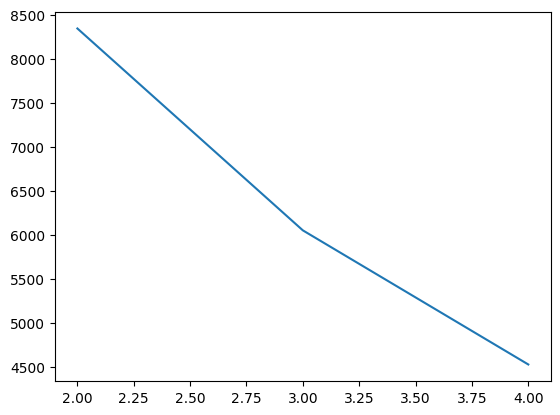

In [73]:
# elbow point 시각화
visualize_inertia([i for i in range(2, 5)], principal_components)

### 군집화 결과 분석 및 시각화

> Elbow point를 기반으로 군집 수 3개 label 선택

In [74]:
# 군집 결과를 좌석 열에 추가
seat_cluster = pd.DataFrame(cseat_data['seat'], columns=['seat'])
seat_cluster['cluster'] = labels_list[1] # 군집 수 : 3개
seat_cluster

,seat,cluster
0,1층 A블록10열 1,1
1,1층 A블록10열 10,1
2,1층 A블록10열 11,2
3,1층 A블록10열 2,1
4,1층 A블록10열 3,1
...,...,...
2504,합창석 H블록4열 5,0
2505,합창석 H블록4열 6,0
2506,합창석 H블록4열 7,0
2507,합창석 H블록4열 8,0


In [75]:
# 군집 분포 확인
seat_cluster['cluster'].value_counts()

cluster
1    1096
2     910
0     503
Name: count, dtype: int64

> 시각화 - box plot

In [76]:
cluster_data = cseat_data.copy() # cseat_data는 군집화 하기 전 데이터
cluster_data

,seat,price,ticket_cancel,골드,무료,그린,싹틔우미,블루,노블,date_diff,할인율
0,1층 A블록10열 1,22438.692098,0.163488,0.106267,0.318801,0.062670,0.049046,0.068120,0.019074,-29.065395,69.945504
1,1층 A블록10열 10,32837.168142,0.191150,0.145133,0.396460,0.118584,0.046018,0.111504,0.019469,-23.930973,66.584071
2,1층 A블록10열 11,36233.333333,0.209259,0.174074,0.448148,0.125926,0.051852,0.129630,0.033333,-24.925926,63.796296
3,1층 A블록10열 2,18582.089552,0.141791,0.106965,0.286070,0.062189,0.037313,0.062189,0.017413,-26.674129,73.370647
4,1층 A블록10열 3,18198.391421,0.120643,0.101877,0.268097,0.053619,0.045576,0.058981,0.024129,-28.450402,73.686327
...,...,...,...,...,...,...,...,...,...,...,...
2504,합창석 H블록4열 5,36014.354067,0.301435,0.287081,0.636364,0.224880,0.095694,0.224880,0.071770,-23.363636,41.684211
2505,합창석 H블록4열 6,32352.657005,0.280193,0.173913,0.565217,0.217391,0.111111,0.173913,0.038647,-24.816425,43.971014
2506,합창석 H블록4열 7,40881.443299,0.304124,0.201031,0.618557,0.309278,0.123711,0.170103,0.036082,-20.288660,41.340206
2507,합창석 H블록4열 8,34852.678571,0.330357,0.294643,0.633929,0.258929,0.111607,0.263393,0.035714,-24.468750,43.750000


In [77]:
# 시각화에 필요없는 변수 제거
cluster_data = cluster_data.drop('seat', axis=1)

# 군집 결과 추가
cluster_data['cluster'] = labels_list[1]

In [78]:
cluster_data

,price,ticket_cancel,골드,무료,그린,싹틔우미,블루,노블,date_diff,할인율,cluster
0,22438.692098,0.163488,0.106267,0.318801,0.062670,0.049046,0.068120,0.019074,-29.065395,69.945504,1
1,32837.168142,0.191150,0.145133,0.396460,0.118584,0.046018,0.111504,0.019469,-23.930973,66.584071,1
2,36233.333333,0.209259,0.174074,0.448148,0.125926,0.051852,0.129630,0.033333,-24.925926,63.796296,2
3,18582.089552,0.141791,0.106965,0.286070,0.062189,0.037313,0.062189,0.017413,-26.674129,73.370647,1
4,18198.391421,0.120643,0.101877,0.268097,0.053619,0.045576,0.058981,0.024129,-28.450402,73.686327,1
...,...,...,...,...,...,...,...,...,...,...,...
2504,36014.354067,0.301435,0.287081,0.636364,0.224880,0.095694,0.224880,0.071770,-23.363636,41.684211,0
2505,32352.657005,0.280193,0.173913,0.565217,0.217391,0.111111,0.173913,0.038647,-24.816425,43.971014,0
2506,40881.443299,0.304124,0.201031,0.618557,0.309278,0.123711,0.170103,0.036082,-20.288660,41.340206,0
2507,34852.678571,0.330357,0.294643,0.633929,0.258929,0.111607,0.263393,0.035714,-24.468750,43.750000,0


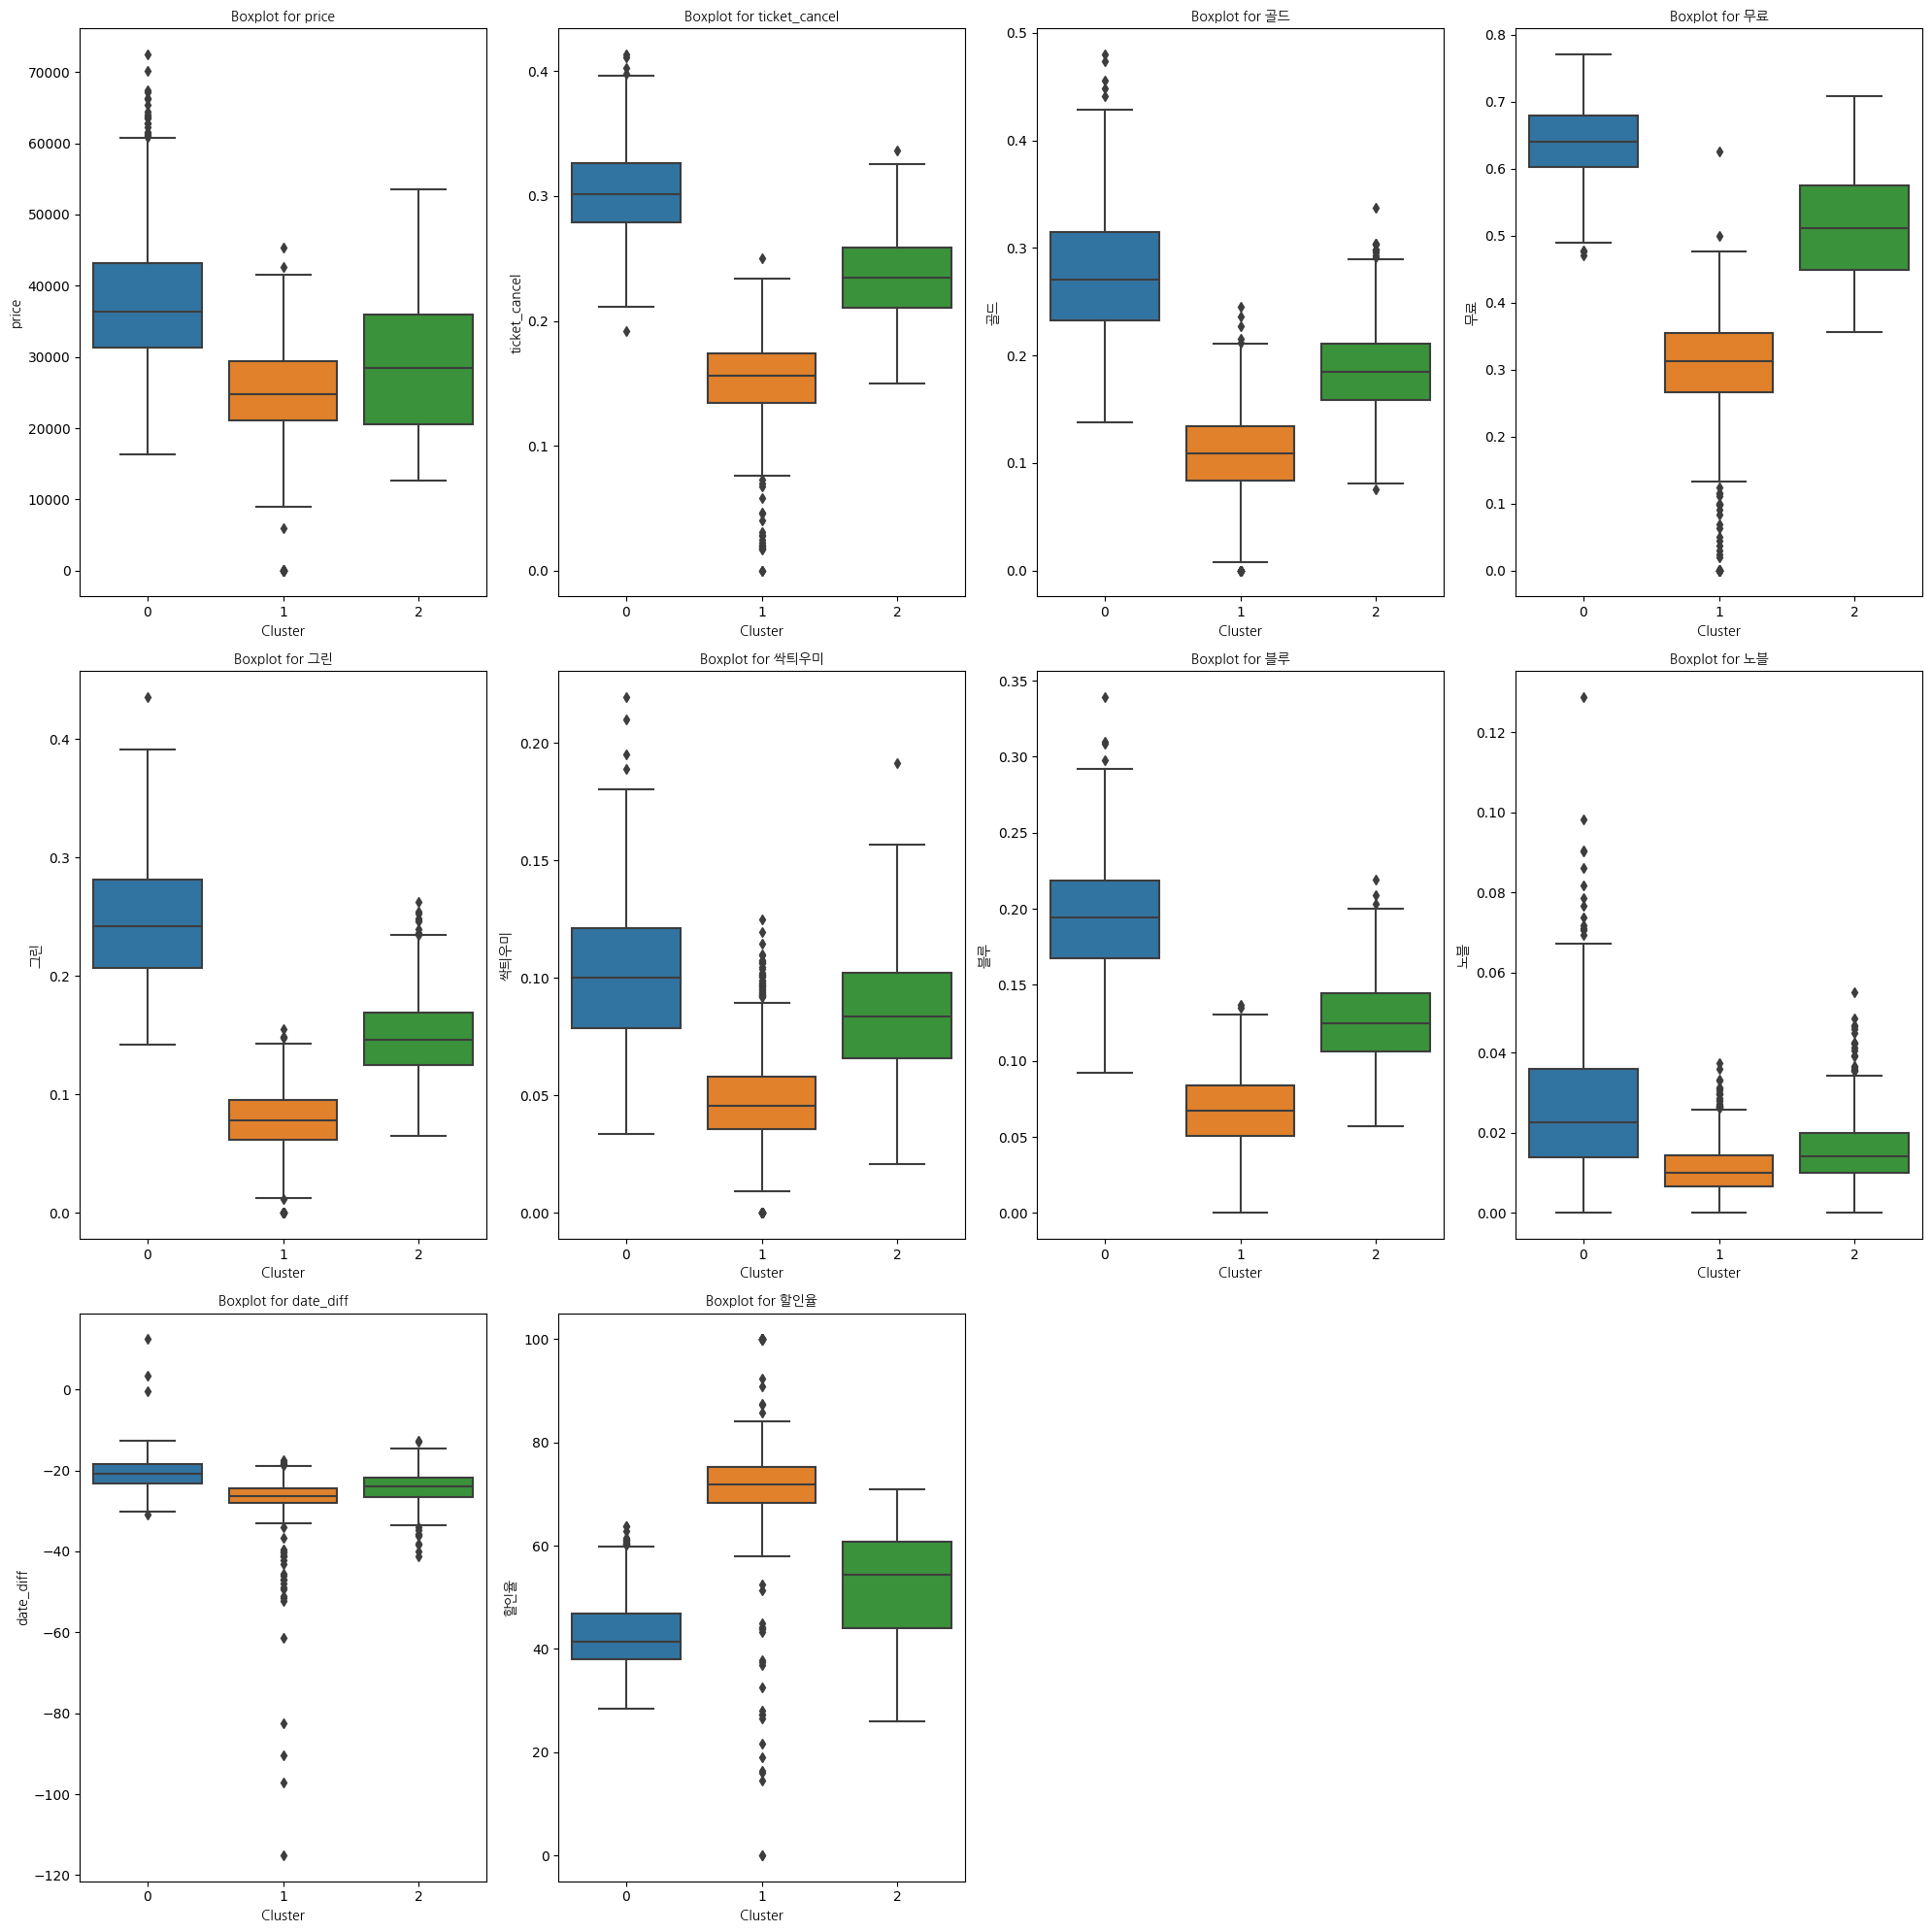

In [79]:
columns_to_plot_1 = cluster_data.columns[:10]  # cluster 열 제외

# 서브플롯의 행과 열 개수 계산
num_rows = 3
num_cols = 4


fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()

# box plot
for i, column in enumerate(columns_to_plot_1):
    ax = axes[i]
    sns.boxplot(x="cluster", y=column, data=cluster_data, ax=ax)
    ax.set_xlabel('Cluster', fontproperties=font_prop)
    ax.set_ylabel(column, fontproperties=font_prop)
    ax.set_title('Boxplot for {}'.format(column), fontproperties=font_prop)

for i in range(len(columns_to_plot_1), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# 4. 공연, 좌석 기반 판매량 예측 수립 모델

## 4.1 콘서트홀 공연, 좌석 군집 기반 데이터 프레임 생성1 - 파생 변수 만들기

### 원본 콘서트홀 데이터에 군집 결과 열 생성

In [80]:
seat_cluster

,seat,cluster
0,1층 A블록10열 1,1
1,1층 A블록10열 10,1
2,1층 A블록10열 11,2
3,1층 A블록10열 2,1
4,1층 A블록10열 3,1
...,...,...
2504,합창석 H블록4열 5,0
2505,합창석 H블록4열 6,0
2506,합창석 H블록4열 7,0
2507,합창석 H블록4열 8,0


In [81]:
concert_data

,age,gender,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,tran_date,tran_time,play_date,play_st_time,seat,price,ticket_cancel,discount_type,performance_code,pre_open_date,open_date,genre,place,running_time,intermission,member_yn,골드,무료,그린,싹틔우미,블루,노블,date_diff,할인율
0,50.0,F,골드,무료,그린,NaN,NaN,2022-01-14,1512,20220204,2000,3층 BOX9 10,10000,2,일반,302,20220114.0,2022-01-15,교향곡,콘서트홀,120,15,Y,1,1,1,0,0,0,1,0.0
4,50.0,M,무료,NaN,NaN,NaN,NaN,2022-02-06,1615,20220302,1930,1층 B블록12열 7,180000,0,일반,897,20220109.0,2022-01-10,독주,콘서트홀,90,0,Y,0,1,0,0,0,0,-27,0.0
5,30.0,F,블루,무료,NaN,NaN,NaN,2018-11-24,1145,20190323,2000,1층 A블록2열 1,144000,2,블루회원 할인20%,528,20181119.0,2018-11-19,교향곡,콘서트홀,100,15,Y,0,1,0,0,1,0,-5,20.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-20,1459,20191109,1700,3층 E블록4열 8,0,0,초대권,44,NaN,2019-10-23,교향곡,콘서트홀,100,15,N,0,0,0,0,0,0,3,100.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-13,954,20190723,2000,2층 D블록8열 4,0,0,초대권,827,20190602.0,2019-06-02,교향곡,콘서트홀,120,20,N,0,0,0,0,0,0,-11,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920853,60.0,F,무료,그린,NaN,NaN,NaN,2021-06-18,1509,20210704,1500,1층 A블록2열 2,90000,2,일반,887,20210618.0,2021-06-20,교향곡,콘서트홀,110,20,Y,0,1,1,0,0,0,2,0.0
1920855,50.0,M,무료,NaN,NaN,NaN,NaN,2023-05-22,1729,20230613,1700,3층 A블록6열 4,10000,0,일반,2825,20230505.0,2023-05-07,교향곡,콘서트홀,120,15,Y,0,1,0,0,0,0,-15,0.0
1920856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-09,1652,20201020,1930,1층 D블록16열 12,0,0,초대권,77,NaN,2020-09-20,클래식,콘서트홀,120,15,N,0,0,0,0,0,0,-19,100.0
1920858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-26,1655,20200818,1930,1층 D블록20열 8,0,0,기획사판매,850,20200719.0,2020-07-20,합창,콘서트홀,110,15,N,0,0,0,0,0,0,-6,100.0


In [82]:
merge_df = pd.merge(concert_data, seat_cluster, on='seat')

In [83]:
merge_df

,age,gender,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,tran_date,tran_time,play_date,play_st_time,seat,price,ticket_cancel,discount_type,performance_code,pre_open_date,open_date,genre,place,running_time,intermission,member_yn,골드,무료,그린,싹틔우미,블루,노블,date_diff,할인율,cluster
0,50.0,F,골드,무료,그린,NaN,NaN,2022-01-14,1512,20220204,2000,3층 BOX9 10,10000,2,일반,302,20220114.0,2022-01-15,교향곡,콘서트홀,120,15,Y,1,1,1,0,0,0,1,0.0,2
1,40.0,F,무료,NaN,NaN,NaN,NaN,2022-05-17,2231,20220612,1700,3층 BOX9 10,50000,0,일반,915,20220423.0,2022-04-24,독주,콘서트홀,110,20,Y,0,1,0,0,0,0,-23,0.0,2
2,20.0,M,무료,싹틔우미,NaN,NaN,NaN,2020-12-16,1401,20201231,1900,3층 BOX9 10,50000,2,일반,318,NaN,2020-12-14,교향곡,콘서트홀,120,15,Y,0,1,0,1,0,0,-2,0.0,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-23,1440,20221228,1930,3층 BOX9 10,0,0,초대권,2748,NaN,2022-12-09,교향곡,콘서트홀,120,0,N,0,0,0,0,0,0,-14,100.0,2
4,50.0,F,골드,무료,NaN,NaN,NaN,2021-06-16,1014,20210717,1700,3층 BOX9 10,60000,0,일반,903,NaN,2021-06-12,크로스오버,콘서트홀,90,0,Y,1,1,0,0,0,0,-4,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-07,1952,20190111,2000,2층 E블록8열 12,21000,0,차액,1233,20181210.0,2018-12-10,클래식,콘서트홀,105,15,N,0,0,0,0,0,0,-28,0.0,1
1096198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-20,1650,20190224,1700,2층 E블록8열 12,19000,0,차액,1400,20181209.0,2018-12-10,성악,콘서트홀,120,20,N,0,0,0,0,0,0,-72,0.0,1
1096199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-19,1952,20190323,2000,2층 E블록8열 12,140000,0,차액,528,20181119.0,2018-11-19,교향곡,콘서트홀,100,15,N,0,0,0,0,0,0,-120,0.0,1
1096200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-03,2122,20190207,2000,2층 E블록8열 12,15000,0,차액,278,NaN,2018-12-02,교향곡,콘서트홀,120,15,N,0,0,0,0,0,0,-63,0.0,1


### 전처리

In [84]:
# 모두 0원으로 예매된 공연은 원가격을 책정할 수 없으므로 삭제
# 0원으로 예매된 perfomace_code 찾기
# Filter rows with price equal to 0
concert_for_zero = data[data['place'] == '콘서트홀']
zero = concert_for_zero[concert_for_zero['price'] == 0].copy()

zero['count_zero'] = 1
zero = zero[['count_zero', 'performance_code']]
zero_agg = zero.groupby('performance_code').sum()
print("<공연별 0원 구매 행 개수 table>")
print(zero_agg.head())

concert_for_count = concert_for_zero.copy()
concert_for_count['count'] = 1
concert_for_count = concert_for_count[['performance_code', 'count']]
con_agg = concert_for_count.groupby('performance_code').sum()
print("<공연별 구매 행 개수 table>")
print(con_agg.head())

# Merge the aggregated DataFrames
zero_count = pd.merge(zero_agg, con_agg, left_index=True, right_index=True)
print("<모두 0원으로 구매된 공연>")
print(zero_count[zero_count['count_zero'] == zero_count['count']])

<공연별 0원 구매 행 개수 table>
                  count_zero
performance_code            
1                        839
3                        291
7                       2879
23                       303
29                      3696
<공연별 구매 행 개수 table>
                  count
performance_code       
1                   877
3                  1107
7                  2958
23                 1241
29                 3696
<모두 0원으로 구매된 공연>
                  count_zero  count
performance_code                   
29                      3696   3696
30                      2208   2208
31                      2210   2210
53                      2239   2239
72                      2210   2210
73                      2467   2467
94                      1668   1668
130                     1642   1642
137                     2737   2737
174                     1036   1036
186                     2496   2496
197                     3106   3106
217                     2233   2233
229                     5166 

### 할인율 변수 만들기

In [85]:
# '할인율' 칼럼 추가
merge_df['할인율'] = merge_df['discount_type'].apply(extract_discount)

In [86]:
# price가 0인 행의 '할인율'이 None인 경우에 100으로 설정
merge_df.loc[(merge_df['price'] == 0) & (merge_df['할인율'].isna()), '할인율'] = 100

In [87]:
merge_df['할인율'].value_counts()

할인율
100.0    579246
10.0      85857
5.0       50938
20.0      50684
30.0      47241
50.0      46656
40.0      29627
15.0      16205
25.0       2340
12.0       1104
60.0        234
75.0         39
35.0         28
80.0         27
Name: count, dtype: int64

In [88]:
# 당일 할인 티켓: 3만원 초과는 모두 1만원, 3만원 이하는 모두 5천원 -> 할인율을 계산할 수가 없어서 가장 가까운 80으로 선택 
# 일만원의 나눔 / 이만원의 기쁨 / 삼만원의 행복 / 오만원의 사랑: S석 10만원인데 개인 의사에 따라 최대 90% 할인율 적용해 자율적 구매 가능했음
# 90% 할인 /       80% 할인 /    70% 할인      /  50% 할인 
# 초중고: 50% 할인 
# 대학: 30% 할인
merge_df.loc[merge_df['discount_type'] == '일만원의 나눔', '할인율'] = 90
merge_df.loc[merge_df['discount_type'] == '이만원의 기쁨', '할인율'] = 80
merge_df.loc[merge_df['discount_type'] == '삼만원의 행복', '할인율'] = 70
merge_df.loc[merge_df['discount_type'] == '오만원의 사랑', '할인율'] = 50

merge_df.loc[merge_df['discount_type'] == '초/중/고등학생 할인(본인만)', '할인율'] = 50
merge_df.loc[merge_df['discount_type'] == '초/중/고등학생 할인', '할인율'] = 50

merge_df.loc[merge_df['discount_type'] == '초/중/고/대학생 할인(본인만)', '할인율'] = 30

In [89]:
merge_df.loc[merge_df['discount_type'] == '당일할인티켓', '할인율'] = 80
merge_df.loc[merge_df['discount_type'] == '당일할인티켓_', '할인율'] = 80

In [90]:
merge_df.loc[merge_df['discount_type'] == '일반', '할인율'] = 0
merge_df.loc[merge_df['discount_type'] == '차액', '할인율'] = 0

In [91]:
merge_df.loc[merge_df['discount_type'] == '공연예매권', '할인율'] = 100

In [92]:
merge_df.loc[merge_df['discount_type'] == '싹틔우미 할인', '할인율'] = 40

In [93]:
merge_df[merge_df['할인율'].isna()]['discount_type'].value_counts()

Series([], Name: count, dtype: int64)

In [94]:
# 위의 discount_type에 해당하는, 할인율이 모호한 데이터들은 전체 데이터셋의 0.07% 밖에 안 되기 때문에 삭제
merge_df = merge_df.dropna(subset=['할인율'])

### 원가 변수 만들기

In [95]:
# 변수가 많기 때문에 필요한 변수만 우선 추출
demand_df = merge_df[['performance_code','cluster', 'price', '할인율', 'ticket_cancel', 'play_date', 'genre', 'running_time']]

In [96]:
demand_df

,performance_code,cluster,price,할인율,ticket_cancel,play_date,genre,running_time
0,302,2,10000,0.0,2,20220204,교향곡,120
1,915,2,50000,0.0,0,20220612,독주,110
2,318,2,50000,0.0,2,20201231,교향곡,120
3,2748,2,0,100.0,0,20221228,교향곡,120
4,903,2,60000,0.0,0,20210717,크로스오버,90
...,...,...,...,...,...,...,...,...
1096197,1233,1,21000,0.0,0,20190111,클래식,105
1096198,1400,1,19000,0.0,0,20190224,성악,120
1096199,528,1,140000,0.0,0,20190323,교향곡,100
1096200,278,1,15000,0.0,0,20190207,교향곡,120


In [97]:
# 할인율이 100%이고, 판매 가격이 0원인 행 제거
demand_df = demand_df[demand_df['할인율'] != 100]
demand_df = demand_df[demand_df['price'] != 0]

In [98]:
# 원가 변수 생성
demand_df['original_price'] = demand_df['price'] / (1 - demand_df['할인율'] / 100.0)
# 예매 가격, 할인율 변수 제거 
demand_df = demand_df.drop(columns = ['price', '할인율'])

In [99]:
# index reset
demand_df.reset_index(inplace=True)
demand_df = demand_df.drop(columns = 'index')

### 계절 변수 만들기

In [100]:
#play_date를 기반으로 공연 월 변수 생성
demand_df['play_date'] = pd.to_datetime(demand_df['play_date'], format='%Y%m%d')
demand_df['month'] = demand_df['play_date'].dt.month_name()

In [101]:
# play_date -> 계절 열
def map_month_to_season(month):
    # 각 월을 해당 계절로 매핑
    season_mapping = {
        'January': 'Winter',
        'February': 'Winter',
        'March': 'Spring',
        'April': 'Spring',
        'May': 'Spring',
        'June': 'Summer',
        'July': 'Summer',
        'August': 'Summer',
        'September': 'Fall',
        'October': 'Fall',
        'November': 'Fall',
        'December': 'Winter'
    }
    return season_mapping[month]

# 'month' 열에 새로운 'season' 열 생성하여 계절로 매핑
demand_df['season'] = demand_df['month'].apply(map_month_to_season)

In [102]:
# 'season' 에 대해 One-Hot Encoding 수행
demand_df = pd.get_dummies(demand_df, columns=['season'])

In [103]:
demand_df = demand_df.drop(columns = ['month', 'play_date'])

### 장르 변수 만들기

In [104]:
# '장르' 열에 대해 One-Hot Encoding 수행
demand_df = pd.get_dummies(demand_df, columns=['genre'])

## 4.2 콘서트홀 공연, 좌석 군집 기반 데이터 프레임 생성2 - 데이터 프레임 만들기

> 공연별/좌석별 판매량 예측 모델링을 하기 위해선 공연 및 좌석의 특성을 가진 데이터가 필요함.<br>
따라서 performance_code, cluster 열을 기준으로 groupby 해주고, 앞서 만들어 놓은 변수들을 이용하여 데이터 프레임을 생성함.

In [105]:
demand_df.columns

Index(['performance_code', 'cluster', 'ticket_cancel', 'running_time',
       'original_price', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'genre_가족극', 'genre_교향곡', 'genre_기타', 'genre_독주',
       'genre_복합장르', 'genre_성악', 'genre_실내악', 'genre_오페라', 'genre_재즈',
       'genre_콘서트', 'genre_크로스오버', 'genre_클래식', 'genre_합창'],
      dtype='object')

In [106]:
# 판매량 계산을 위한 변수 생성
demand_df['count'] = 1
demand_df['ticket_cancel'] = demand_df['ticket_cancel']/2

In [107]:
# performance_code, cluster 열을 기준으로 groupby 
demand_count = demand_df.groupby(['performance_code', 'cluster']).agg({
    **{col: 'max' for col in demand_df.columns if col not in ['ticket_cancel', 'running_time', 'original_price', 'count', 'cluster', 'performance_code']},
    'ticket_cancel':'sum',
    'count':'sum',
    'original_price': 'mean',
    'running_time':'mean'
}).reset_index()

In [108]:
demand_count

,performance_code,cluster,season_Fall,season_Spring,season_Summer,season_Winter,genre_가족극,genre_교향곡,genre_기타,genre_독주,genre_복합장르,genre_성악,genre_실내악,genre_오페라,genre_재즈,genre_콘서트,genre_크로스오버,genre_클래식,genre_합창,ticket_cancel,count,original_price,running_time
0,1,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,1.0,19,58947.368421,100.0
1,1,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,2.0,8,61250.000000,100.0
2,1,2,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0.0,11,59090.909091,100.0
3,3,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,140.0,248,84153.225806,100.0
4,3,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,44.0,193,94196.891192,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,2937,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,46.0,197,94524.178466,120.0
1945,2937,2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,60.0,197,72532.727758,120.0
1946,2938,0,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,423.0,809,95898.119836,85.0
1947,2938,1,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,361.0,884,142635.746606,85.0


> 판매량 변수 생성

In [109]:
demand_count['demand'] = demand_count['count'] - demand_count['ticket_cancel']
before_model = demand_count.drop(columns = ['ticket_cancel', 'count'])

> before_model 전처리

In [110]:
before_model.describe()

,performance_code,cluster,original_price,running_time,demand
count,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000
mean,1282.578758,1.000513,65998.164497,109.889909,160.491021
std,905.641905,0.817230,41075.321451,17.066986,161.567144
min,1.000000,0.000000,8840.000000,0.000000,0.000000
25%,441.000000,0.000000,36060.975610,100.000000,44.000000
50%,1176.000000,1.000000,59308.565531,110.000000,113.000000
75%,2132.000000,2.000000,84777.777778,120.000000,222.000000
max,2938.000000,2.000000,404664.798360,210.000000,1308.000000


In [111]:
# 원가 소수점 버리고 정수로 변환
before_model['original_price'] = before_model['original_price'].astype(int)

In [112]:
# performance code 에 새로운 label 부여
label_encoder = LabelEncoder()
before_model['performance_code_encoded'] = label_encoder.fit_transform(before_model['performance_code'])

## 4.3 새로운 데이터 프레임 기반 모델링

### 모델링을 train-test data 생성`

In [113]:
before_model

,performance_code,cluster,season_Fall,season_Spring,season_Summer,season_Winter,genre_가족극,genre_교향곡,genre_기타,genre_독주,genre_복합장르,genre_성악,genre_실내악,genre_오페라,genre_재즈,genre_콘서트,genre_크로스오버,genre_클래식,genre_합창,original_price,running_time,demand,performance_code_encoded
0,1,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,58947,100.0,18.0,0
1,1,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,61250,100.0,6.0,0
2,1,2,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,59090,100.0,11.0,0
3,3,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,84153,100.0,108.0,1
4,3,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,94196,100.0,149.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,2937,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,94524,120.0,151.0,650
1945,2937,2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,72532,120.0,137.0,650
1946,2938,0,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,95898,85.0,386.0,651
1947,2938,1,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,142635,85.0,523.0,651


In [114]:
# Feature (X): 'performance_code_encoded', 'original_price', .....
X =  before_model.drop(['demand','performance_code','season_Winter','genre_기타'], axis=1) # one hot encoding -> 하나의 열 제거
# Target (y): 'demand'
y = before_model['demand']

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### RandomForestRegressor

In [116]:
# RandomForestRegressor 모델 생성
model_rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 정의
param_grid_rf = {
    'n_estimators': [500, 1000, 2000],  # 트리의 개수
    'max_depth': [None, 5, 10, 20],  # 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],  # 내부 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4, 5]  # 리프 노드에 필요한 최소 샘플 수
}

# GridSearchCV를 사용하여 그리드 서치 수행
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터 및 모델 출력
print("Best Parameters: ", grid_search_rf.best_params_)
print("Best Estimator: ", grid_search_rf.best_estimator_)

# 테스트 데이터로 모델 성능 평가
best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"R-squared (Random Forest): {r2_rf}")

Best Parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Best Estimator:  RandomForestRegressor(max_depth=20, n_estimators=1000, random_state=42)
R-squared (Random Forest): 0.4414309800236428


### GradientBoostingRegressor

In [117]:
# GradientBoostingRegressor 모델 생성
model = GradientBoostingRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [500, 1000, 2000],  # 트리의 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [5, 6, 7],  # 트리의 최대 깊이
}

# GridSearchCV를 사용하여 그리드 서치 수행
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 및 모델 출력
print("Best Parameters: ", grid_search.best_params_)
print("Best Estimator: ", grid_search.best_estimator_)

# 테스트 데이터로 모델 성능 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"R-squared: {r2}")

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 2000}
Best Estimator:  GradientBoostingRegressor(max_depth=5, n_estimators=2000, random_state=42)
R-squared: 0.6600023310540349


### GradientBoostingRegressor using k-fold cross-validation

In [118]:
# Feature (X): 'performance_code_encoded', 'original_price', ......
X = before_model.drop(['demand', 'performance_code', 'season_Winter', 'genre_기타'], axis=1)  # one hot encoding -> 하나의 열 제거

# Target (y): 'demand'
y = before_model['demand']

# KFold를 사용하여 5-fold Cross-validation 수행
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_model = None
best_r2 = float('-inf')  # Initialize with a very small value

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 모델 생성 (최적 파라미터로)
    model = GradientBoostingRegressor(n_estimators=grid_search.best_params_['n_estimators'],
                                      learning_rate=grid_search.best_params_['learning_rate'],
                                      max_depth=grid_search.best_params_['max_depth'],
                                      random_state=42)
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 검증 데이터에 대한 예측
    y_pred = model.predict(X_val)
    
    r2 = r2_score(y_val, y_pred)
    
    # 최적 모델 업데이트
    if r2 > best_r2:
        best_r2 = r2
        best_model = model

print("Best R-squared:", best_r2)
print("Best Model:", best_model)

Best R-squared: 0.65923340417691
Best Model: GradientBoostingRegressor(max_depth=5, n_estimators=2000, random_state=42)


# 5. 가격 변동 시 판매량 예측 및 가격탄력성 계산

### train data를 이용하여 sample data 생성

In [119]:
# X_train과 y_train을 합치기
train_data = pd.concat([X_train, y_train], axis=1)
train_data[(train_data['genre_클래식'] == True) & (train_data['season_Fall'] == True)]

,cluster,season_Fall,season_Spring,season_Summer,genre_가족극,genre_교향곡,genre_독주,genre_복합장르,genre_성악,genre_실내악,genre_오페라,genre_재즈,genre_콘서트,genre_크로스오버,genre_클래식,genre_합창,original_price,running_time,performance_code_encoded,demand
3,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,84153,100.000000,1,108.0
4,1,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,94196,100.000000,1,149.0
5,2,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,66773,100.000000,1,213.0
33,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,27142,90.000000,11,21.0
35,2,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,43750,90.000000,11,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,2,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,49512,120.000000,614,19.0
1844,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,10000,130.000000,617,212.0
1928,0,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,33608,105.652174,645,19.0
1929,1,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,32500,102.500000,645,8.0


In [124]:
# 판매량 예측을 위한 임의의 data 생성  - 가격에 변화를 주어 판매량 변화 예측
sample_data = pd.DataFrame({
    'cluster': [0, 0],
    'season_Fall': [1, 1],
    'season_Spring': [0, 0],
    'season_Summer': [0, 0],
    'genre_가족극': [0, 0],
    'genre_교향곡': [0, 0],
    'genre_독주': [0, 0],
    'genre_복합장르': [0, 0],
    'genre_성악': [0, 0],
    'genre_실내악': [0, 0],
    'genre_오페라': [0, 0],
    'genre_재즈': [0, 0],
    'genre_콘서트': [0, 0],
    'genre_크로스오버': [0, 0],
    'genre_클래식': [1, 1],
    'genre_합창': [0, 0],
    'original_price': [10000, 50000],
    'running_time': [130, 130],
    'performance_code_encoded': [617, 617]
})
sample_data

,cluster,season_Fall,season_Spring,season_Summer,genre_가족극,genre_교향곡,genre_독주,genre_복합장르,genre_성악,genre_실내악,genre_오페라,genre_재즈,genre_콘서트,genre_크로스오버,genre_클래식,genre_합창,original_price,running_time,performance_code_encoded
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,10000,130,617
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,50000,130,617


### best_model에 sample data 대입하여 가격 상승 시 판매량 예측

In [125]:
#판매량 예측
predict = best_model.predict(sample_data)
predict

array([212.14848942, 108.22801069])

In [126]:
# 가격 탄력성 계산 함수
def calculate_price_elasticity(initial_price, new_price, initial_demand, new_demand):
    """
    Calculate price elasticity of demand.

    Parameters:
    initial_price (float): Initial price.
    new_price (float): New price.
    initial_demand (float): Initial demand.
    new_demand (float): New demand.

    Returns:
    float: Price elasticity of demand.
    """
    price_change_percentage = ((new_price - initial_price) / initial_price) * 100
    demand_change_percentage = ((new_demand - initial_demand) / initial_demand) * 100

    price_elasticity = abs(demand_change_percentage / price_change_percentage)

    return price_elasticity

# 예시 가격과 판매량
initial_price = sample_data['original_price'][0]  # 기존 가격
new_price = sample_data['original_price'][1]  # 새로운 가격
initial_demand = predict[0]  # 기존 판매량
new_demand = predict[1]  # 새로운 판매량

# 가격 탄력성 계산
elasticity = calculate_price_elasticity(initial_price, new_price, initial_demand, new_demand)
print("Price Elasticity of Demand:", elasticity)

Price Elasticity of Demand: 0.12246195932363163


In [127]:
sample_data # 가격 10000원에서 50000원으로 상승
predict # 판매량 감소
# 가격 탄력성 : 0.1225

array([212.14848942, 108.22801069])